In [1]:
import pandas as pd
transaction_df = pd.read_excel('Shopping-cart-dataset.xlsx')
grouped = transaction_df.groupby('Invoice')['Description'].apply(list)
new_df = pd.DataFrame({'Items': grouped})
transaction_df['Description'].fillna('Unknown', inplace=True)
grouped = transaction_df.groupby('Invoice')['Description'].apply(list)
new_df = pd.DataFrame({'Items': grouped})
new_df.reset_index(inplace=True)
new_df.rename(columns={'Invoice': 'TID'}, inplace=True)
print(new_df)
new_df = new_df.drop('TID', axis=1)
new_df
new_df.index.rename('TID', inplace=True)
new_df
new_df['Items'] = new_df['Items'].apply(lambda x: ','.join(map(str, x)))
new_df

new_df.index.rename('TID', inplace=True)
new_df.rename(columns={'Items' : 'item_list'}, inplace=True)
trans_df = new_df.item_list.str.split(',')
trans_df

           TID                                              Items
0     536365.0  [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...
1     536366.0  [HAND WARMER UNION JACK, HAND WARMER RED POLKA...
2     536367.0  [ASSORTED COLOUR BIRD ORNAMENT, POPPY'S PLAYHO...
3     536368.0  [JAM MAKING SET WITH JARS, RED COAT RACK PARIS...
4     536369.0                         [BATH BUILDING BLOCK WORD]
...        ...                                                ...
2343   C540417  [CHILLI LIGHTS, TEA TIME PARTY BUNTING, PICNIC...
2344   C540470                      [WHITE TEA,COFFEE,SUGAR JARS]
2345   C540503  [CAKE STAND VICTORIAN FILIGREE LARGE, 3 HEARTS...
2346   C540527       [DOCTOR'S BAG SOFT TOY, GARDEN PATH JOURNAL]
2347   C540535  [PINK LARGE JEWELED PHOTOFRAME, WOOD 2 DRAWER ...

[2348 rows x 2 columns]


TID
0       [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...
1       [HAND WARMER UNION JACK, HAND WARMER RED POLKA...
2       [ASSORTED COLOUR BIRD ORNAMENT, POPPY'S PLAYHO...
3       [JAM MAKING SET WITH JARS, RED COAT RACK PARIS...
4                              [BATH BUILDING BLOCK WORD]
                              ...                        
2343    [CHILLI LIGHTS, TEA TIME PARTY BUNTING, PICNIC...
2344                      [WHITE TEA, COFFEE, SUGAR JARS]
2345    [CAKE STAND VICTORIAN FILIGREE LARGE, 3 HEARTS...
2346         [DOCTOR'S BAG SOFT TOY, GARDEN PATH JOURNAL]
2347    [PINK LARGE JEWELED PHOTOFRAME, WOOD 2 DRAWER ...
Name: item_list, Length: 2348, dtype: object

In [13]:
from collections import Counter

def prune(data, supp, k):
#     print(data)
    freq_items = []
    print("Item_set of size:",k)
    for idx, row in data.iterrows():
        print(f'Itemset {row["item_sets"]} is candidate')
        if row['supp_count'] >= supp:
            freq_items.append(row['item_sets'])
            print(f'Itemset {row["item_sets"]} has qualified')
        else:
            print(f'Itemset {row["item_sets"]} has been pruned due to low support count')
    freq_df = pd.DataFrame({'item_sets': freq_items})
    freq_df['supp_count'] = freq_df['item_sets'].apply(lambda x: count_support(x, trans_df))
    return freq_df


def count_support(itemset, trans_data):
    count = 0
    for transaction in trans_data:
        if set(itemset).issubset(set(transaction)):
            count += 1
    return count


def count_itemset(trans_data, itemsets):
    count_item = {}
    for item_set in itemsets:
        count_item[item_set] = sum([1 for transaction in trans_data if set(item_set).issubset(set(transaction))])
    data = pd.DataFrame()
    data['item_sets'] = count_item.keys()
    data['supp_count'] = count_item.values()
    return data




def count_item(trans_items):
    flat_items = [item for trans in trans_items for item in trans]
    item_counts = Counter(flat_items)
    data = pd.DataFrame({'item_sets': list(item_counts.keys()), 'supp_count': list(item_counts.values())})
    data = data.sort_values('item_sets')
    print('each item count ', data)
    return data


def join(list_of_items):
    itemsets = []
    for i, item1 in enumerate(list_of_items):
        for j in range(i+1, len(list_of_items)):
            item2 = list_of_items[j]
            if type(item1) is str:
                tuples = (item1, item2)
                itemsets.append(tuples)
            else:
                if item1[:-1] == item2[:-1]:
                    tuples = item1 + (item2[-1],)
                    itemsets.append(tuples)
    if not itemsets:
        return None
    print('itemsets', itemsets)
    return itemsets

def apriori(trans_data, supp=3, con=0.5, max_k=5):
    freq = pd.DataFrame()
    k = 1
    while k <= max_k:
        if k == 1:
            df = count_item(trans_data)
        else:
            df = count_itemset(trans_data, itemsets)
        df = prune(df, supp, k)
        if len(df) == 0:
            break
        freq = df[df['supp_count'] >= supp]
        if len(freq) == 0:
            break
        itemsets = join(df['item_sets'])
        if itemsets is None:
            break
        k += 1
    return freq


In [14]:
def calculate_conf(value1, value2):
    return round(int(value1)/int(value2) * 100, 2)

def all_rules(freq_item_sets):
    count_data = count_item(trans_df)
    confidences = {}
    for row in freq_item_sets.item_sets:
        for i in range(len(row)):
            for j in range(len(row)):
                if i != j:
                    itemset_A = row[i]
                    itemset_B = row[j]
                    supp_count_A = count_data[count_data.item_sets == itemset_A].supp_count.item()
                    supp_count_AB = freq_item_sets[freq_item_sets.item_sets == row].supp_count.item()
                    conf = calculate_conf(supp_count_AB, supp_count_A)
                    confidences[(itemset_A, itemset_B)] = conf

    conf_df = pd.DataFrame(confidences.items(), columns=['item_set', 'confidence'])
    conf_df['item_set'] = conf_df['item_set'].apply(lambda x: tuple(sorted(x)))
    conf_df = conf_df.groupby('item_set').agg({'confidence': 'max'}).reset_index()
    return conf_df



In [15]:
import time

start_time = time.time()
freq_item_sets = apriori(trans_df,50)
s=all_rules(freq_item_sets)
strong_rules = s[s.confidence >= 80.0]
weak_rules = s[s.confidence < 80.0]
end_time = time.time()
runtime = end_time - start_time
print("Runtime: {} seconds".format(runtime))

each item count                             item_sets  supp_count
1616                                           8
190                                           72
1228                       1 HANGER           21
1407                          3 TIER           1
617    4 PURPLE FLOCK DINNER CANDLES           4
...                              ...         ...
2177                           check           2
2179                         damages           1
2414                          faulty           1
1764                         pack/12           1
2791      reverse 21/5/10 adjustment           2

[2863 rows x 2 columns]
Item_set of size: 1
Itemset  is candidate
Itemset  has been pruned due to low support count
Itemset   is candidate
Itemset   has qualified
Itemset  1 HANGER  is candidate
Itemset  1 HANGER  has been pruned due to low support count
Itemset  3 TIER is candidate
Itemset  3 TIER has been pruned due to low support count
Itemset  4 PURPLE FLOCK DINNER CANDLES is candidate
I

Itemset BLUE CHARLIE+LOLA PERSONAL DOORSIGN is candidate
Itemset BLUE CHARLIE+LOLA PERSONAL DOORSIGN has been pruned due to low support count
Itemset BLUE CHENILLE SHAGGY CUSHION COVER  is candidate
Itemset BLUE CHENILLE SHAGGY CUSHION COVER  has been pruned due to low support count
Itemset BLUE CIRCLES DESIGN MONKEY DOLL is candidate
Itemset BLUE CIRCLES DESIGN MONKEY DOLL has been pruned due to low support count
Itemset BLUE CIRCLES DESIGN TEDDY is candidate
Itemset BLUE CIRCLES DESIGN TEDDY has been pruned due to low support count
Itemset BLUE COAT RACK PARIS FASHION is candidate
Itemset BLUE COAT RACK PARIS FASHION has been pruned due to low support count
Itemset BLUE DAISY MOBILE is candidate
Itemset BLUE DAISY MOBILE has been pruned due to low support count
Itemset BLUE DINER WALL CLOCK is candidate
Itemset BLUE DINER WALL CLOCK has been pruned due to low support count
Itemset BLUE DRAGONFLY HELICOPTER is candidate
Itemset BLUE DRAGONFLY HELICOPTER has been pruned due to low supp

Itemset CLEAR LOVE BIRD T-LIGHT HOLDER has been pruned due to low support count
Itemset CLEAR MILKSHAKE GLASS is candidate
Itemset CLEAR MILKSHAKE GLASS has been pruned due to low support count
Itemset CLOTHES PEGS RETROSPOT PACK 24  is candidate
Itemset CLOTHES PEGS RETROSPOT PACK 24  has qualified
Itemset COAL BLACK is candidate
Itemset COAL BLACK has been pruned due to low support count
Itemset COCKLE SHELL DISH is candidate
Itemset COCKLE SHELL DISH has been pruned due to low support count
Itemset COFFEE is candidate
Itemset COFFEE has qualified
Itemset COFFEE MUG APPLES DESIGN is candidate
Itemset COFFEE MUG APPLES DESIGN has been pruned due to low support count
Itemset COFFEE MUG BLUE PAISLEY DESIGN is candidate
Itemset COFFEE MUG BLUE PAISLEY DESIGN has been pruned due to low support count
Itemset COFFEE MUG CAT + BIRD DESIGN is candidate
Itemset COFFEE MUG CAT + BIRD DESIGN has qualified
Itemset COFFEE MUG DOG + BALL DESIGN is candidate
Itemset COFFEE MUG DOG + BALL DESIGN has 

Itemset GINGHAM HEART  DOORSTOP RED is candidate
Itemset GINGHAM HEART  DOORSTOP RED has been pruned due to low support count
Itemset GINGHAM OVEN GLOVE RED HEART  is candidate
Itemset GINGHAM OVEN GLOVE RED HEART  has been pruned due to low support count
Itemset GINGHAM ROSE WRAP is candidate
Itemset GINGHAM ROSE WRAP has been pruned due to low support count
Itemset GIRLS ALPHABET IRON ON PATCHES  is candidate
Itemset GIRLS ALPHABET IRON ON PATCHES  has been pruned due to low support count
Itemset GIRLS VINTAGE TIN SEASIDE BUCKET is candidate
Itemset GIRLS VINTAGE TIN SEASIDE BUCKET has been pruned due to low support count
Itemset GIRLY PINK TOOL SET is candidate
Itemset GIRLY PINK TOOL SET has been pruned due to low support count
Itemset GLAMOROUS  MUG is candidate
Itemset GLAMOROUS  MUG has been pruned due to low support count
Itemset GLASS  BEURRE DISH is candidate
Itemset GLASS  BEURRE DISH has been pruned due to low support count
Itemset GLASS AND PAINTED BEADS BRACELET OL is can

Itemset LETTER "F" BLING KEY RING is candidate
Itemset LETTER "F" BLING KEY RING has been pruned due to low support count
Itemset LETTER "G" BLING KEY RING is candidate
Itemset LETTER "G" BLING KEY RING has been pruned due to low support count
Itemset LETTER "H" BLING KEY RING is candidate
Itemset LETTER "H" BLING KEY RING has been pruned due to low support count
Itemset LETTER "I" BLING KEY RING is candidate
Itemset LETTER "I" BLING KEY RING has been pruned due to low support count
Itemset LETTER "J" BLING KEY RING is candidate
Itemset LETTER "J" BLING KEY RING has been pruned due to low support count
Itemset LETTER "K" BLING KEY RING is candidate
Itemset LETTER "K" BLING KEY RING has been pruned due to low support count
Itemset LETTER "L" BLING KEY RING is candidate
Itemset LETTER "L" BLING KEY RING has been pruned due to low support count
Itemset LETTER "M" BLING KEY RING is candidate
Itemset LETTER "M" BLING KEY RING has been pruned due to low support count
Itemset LETTER "N" BLING

Itemset PACK OF 12 PINK POLKADOT TISSUES is candidate
Itemset PACK OF 12 PINK POLKADOT TISSUES has been pruned due to low support count
Itemset PACK OF 12 RED RETROSPOT TISSUES  is candidate
Itemset PACK OF 12 RED RETROSPOT TISSUES  has been pruned due to low support count
Itemset PACK OF 12 SKULL TISSUES is candidate
Itemset PACK OF 12 SKULL TISSUES has been pruned due to low support count
Itemset PACK OF 12 SPACEBOY TISSUES is candidate
Itemset PACK OF 12 SPACEBOY TISSUES has been pruned due to low support count
Itemset PACK OF 12 STICKY BUNNIES is candidate
Itemset PACK OF 12 STICKY BUNNIES has been pruned due to low support count
Itemset PACK OF 12 SUKI TISSUES  is candidate
Itemset PACK OF 12 SUKI TISSUES  has qualified
Itemset PACK OF 12 TRADITIONAL CRAYONS is candidate
Itemset PACK OF 12 TRADITIONAL CRAYONS has been pruned due to low support count
Itemset PACK OF 12 WOODLAND TISSUES  is candidate
Itemset PACK OF 12 WOODLAND TISSUES  has been pruned due to low support count
Items

Itemset RED RETROSPOT TAPE has been pruned due to low support count
Itemset RED RETROSPOT TEA CUP AND SAUCER  is candidate
Itemset RED RETROSPOT TEA CUP AND SAUCER  has been pruned due to low support count
Itemset RED RETROSPOT TISSUE BOX is candidate
Itemset RED RETROSPOT TISSUE BOX has been pruned due to low support count
Itemset RED RETROSPOT TRADITIONAL TEAPOT  is candidate
Itemset RED RETROSPOT TRADITIONAL TEAPOT  has qualified
Itemset RED RETROSPOT UMBRELLA is candidate
Itemset RED RETROSPOT UMBRELLA has been pruned due to low support count
Itemset RED RETROSPOT WASHBAG is candidate
Itemset RED RETROSPOT WASHBAG has been pruned due to low support count
Itemset RED RETROSPOT WRAP  is candidate
Itemset RED RETROSPOT WRAP  has been pruned due to low support count
Itemset RED ROSE AND LACE C/COVER is candidate
Itemset RED ROSE AND LACE C/COVER has been pruned due to low support count
Itemset RED SHARK HELICOPTER is candidate
Itemset RED SHARK HELICOPTER has been pruned due to low sup

Itemset SMALL CAMPHOR WOOD FIELD  MUSHROOM is candidate
Itemset SMALL CAMPHOR WOOD FIELD  MUSHROOM has been pruned due to low support count
Itemset SMALL CHINESE STYLE SCISSOR is candidate
Itemset SMALL CHINESE STYLE SCISSOR has been pruned due to low support count
Itemset SMALL CHOCOLATES PINK BOWL is candidate
Itemset SMALL CHOCOLATES PINK BOWL has been pruned due to low support count
Itemset SMALL CHUNKY GLASS ROMAN  BOWL is candidate
Itemset SMALL CHUNKY GLASS ROMAN  BOWL has been pruned due to low support count
Itemset SMALL DOLLY MIX DESIGN ORANGE BOWL is candidate
Itemset SMALL DOLLY MIX DESIGN ORANGE BOWL has been pruned due to low support count
Itemset SMALL FOLDING SCISSOR(POINTED EDGE) is candidate
Itemset SMALL FOLDING SCISSOR(POINTED EDGE) has been pruned due to low support count
Itemset SMALL FOLKART STAR CHRISTMAS DEC is candidate
Itemset SMALL FOLKART STAR CHRISTMAS DEC has been pruned due to low support count
Itemset SMALL GLASS HEART TRINKET POT is candidate
Itemset S

Itemset WOOD STAMP SET THANK YOU has been pruned due to low support count
Itemset WOOD STOCKING CHRISTMAS SCANDISPOT is candidate
Itemset WOOD STOCKING CHRISTMAS SCANDISPOT has been pruned due to low support count
Itemset WOODEN ADVENT CALENDAR CREAM is candidate
Itemset WOODEN ADVENT CALENDAR CREAM has been pruned due to low support count
Itemset WOODEN ADVENT CALENDAR RED is candidate
Itemset WOODEN ADVENT CALENDAR RED has been pruned due to low support count
Itemset WOODEN BOX ADVENT CALENDAR  is candidate
Itemset WOODEN BOX ADVENT CALENDAR  has been pruned due to low support count
Itemset WOODEN BOX OF DOMINOES is candidate
Itemset WOODEN BOX OF DOMINOES has qualified
Itemset WOODEN CROQUET GARDEN SET is candidate
Itemset WOODEN CROQUET GARDEN SET has been pruned due to low support count
Itemset WOODEN FRAME ANTIQUE WHITE  is candidate
Itemset WOODEN FRAME ANTIQUE WHITE  has qualified
Itemset WOODEN HAPPY BIRTHDAY GARLAND is candidate
Itemset WOODEN HAPPY BIRTHDAY GARLAND has been 

itemsets [(' ', ' SET 2 TEA TOWELS I LOVE LONDON '), (' ', '12 PENCILS SMALL TUBE RED RETROSPOT'), (' ', '12 PENCILS SMALL TUBE SKULL'), (' ', '3 HEARTS HANGING DECORATION RUSTIC'), (' ', '3 STRIPEY MICE FELTCRAFT'), (' ', '4 TRADITIONAL SPINNING TOPS'), (' ', '6 RIBBONS RUSTIC CHARM'), (' ', '60 CAKE CASES VINTAGE CHRISTMAS'), (' ', '60 TEATIME FAIRY CAKE CASES'), (' ', '72 SWEETHEART FAIRY CAKE CASES'), (' ', 'AIRLINE BAG VINTAGE TOKYO 78'), (' ', 'ALARM CLOCK BAKELIKE CHOCOLATE'), (' ', 'ALARM CLOCK BAKELIKE GREEN'), (' ', 'ALARM CLOCK BAKELIKE IVORY'), (' ', 'ALARM CLOCK BAKELIKE ORANGE'), (' ', 'ALARM CLOCK BAKELIKE PINK'), (' ', 'ALARM CLOCK BAKELIKE RED '), (' ', 'ANTIQUE SILVER TEA GLASS ETCHED'), (' ', 'APPLE BATH SPONGE'), (' ', 'ASSORTED COLOUR BIRD ORNAMENT'), (' ', 'BATHROOM METAL SIGN'), (' ', 'BEWARE OF THE CAT METAL SIGN '), (' ', 'BINGO SET'), (' ', 'BLUE HARMONICA IN BOX '), (' ', 'BOX OF 24 COCKTAIL PARASOLS'), (' ', 'CANDLEHOLDER PINK HANGING HEART'), (' ', 'CERAMIC

Item_set of size: 2
Itemset (' ', ' SET 2 TEA TOWELS I LOVE LONDON ') is candidate
Itemset (' ', ' SET 2 TEA TOWELS I LOVE LONDON ') has been pruned due to low support count
Itemset (' ', '12 PENCILS SMALL TUBE RED RETROSPOT') is candidate
Itemset (' ', '12 PENCILS SMALL TUBE RED RETROSPOT') has been pruned due to low support count
Itemset (' ', '12 PENCILS SMALL TUBE SKULL') is candidate
Itemset (' ', '12 PENCILS SMALL TUBE SKULL') has been pruned due to low support count
Itemset (' ', '3 HEARTS HANGING DECORATION RUSTIC') is candidate
Itemset (' ', '3 HEARTS HANGING DECORATION RUSTIC') has been pruned due to low support count
Itemset (' ', '3 STRIPEY MICE FELTCRAFT') is candidate
Itemset (' ', '3 STRIPEY MICE FELTCRAFT') has been pruned due to low support count
Itemset (' ', '4 TRADITIONAL SPINNING TOPS') is candidate
Itemset (' ', '4 TRADITIONAL SPINNING TOPS') has been pruned due to low support count
Itemset (' ', '6 RIBBONS RUSTIC CHARM') is candidate
Itemset (' ', '6 RIBBONS RUST

Itemset (' SET 2 TEA TOWELS I LOVE LONDON ', 'HAND WARMER OWL DESIGN') has been pruned due to low support count
Itemset (' SET 2 TEA TOWELS I LOVE LONDON ', 'HAND WARMER RED RETROSPOT') is candidate
Itemset (' SET 2 TEA TOWELS I LOVE LONDON ', 'HAND WARMER RED RETROSPOT') has been pruned due to low support count
Itemset (' SET 2 TEA TOWELS I LOVE LONDON ', 'HAND WARMER SCOTTY DOG DESIGN') is candidate
Itemset (' SET 2 TEA TOWELS I LOVE LONDON ', 'HAND WARMER SCOTTY DOG DESIGN') has been pruned due to low support count
Itemset (' SET 2 TEA TOWELS I LOVE LONDON ', 'HAND WARMER UNION JACK') is candidate
Itemset (' SET 2 TEA TOWELS I LOVE LONDON ', 'HAND WARMER UNION JACK') has been pruned due to low support count
Itemset (' SET 2 TEA TOWELS I LOVE LONDON ', 'HANGING HEART ZINC T-LIGHT HOLDER') is candidate
Itemset (' SET 2 TEA TOWELS I LOVE LONDON ', 'HANGING HEART ZINC T-LIGHT HOLDER') has been pruned due to low support count
Itemset (' SET 2 TEA TOWELS I LOVE LONDON ', 'HEART OF WICKER 

Itemset ('12 PENCILS SMALL TUBE RED RETROSPOT', 'SET/20 RED RETROSPOT PAPER NAPKINS ') is candidate
Itemset ('12 PENCILS SMALL TUBE RED RETROSPOT', 'SET/20 RED RETROSPOT PAPER NAPKINS ') has been pruned due to low support count
Itemset ('12 PENCILS SMALL TUBE RED RETROSPOT', 'SET/5 RED RETROSPOT LID GLASS BOWLS') is candidate
Itemset ('12 PENCILS SMALL TUBE RED RETROSPOT', 'SET/5 RED RETROSPOT LID GLASS BOWLS') has been pruned due to low support count
Itemset ('12 PENCILS SMALL TUBE RED RETROSPOT', 'SILVER HANGING T-LIGHT HOLDER') is candidate
Itemset ('12 PENCILS SMALL TUBE RED RETROSPOT', 'SILVER HANGING T-LIGHT HOLDER') has been pruned due to low support count
Itemset ('12 PENCILS SMALL TUBE RED RETROSPOT', 'SINGLE HEART ZINC T-LIGHT HOLDER') is candidate
Itemset ('12 PENCILS SMALL TUBE RED RETROSPOT', 'SINGLE HEART ZINC T-LIGHT HOLDER') has been pruned due to low support count
Itemset ('12 PENCILS SMALL TUBE RED RETROSPOT', 'SMALL GLASS HEART TRINKET POT') is candidate
Itemset ('12

Itemset ('3 HEARTS HANGING DECORATION RUSTIC', 'ENGLISH ROSE HOT WATER BOTTLE') is candidate
Itemset ('3 HEARTS HANGING DECORATION RUSTIC', 'ENGLISH ROSE HOT WATER BOTTLE') has been pruned due to low support count
Itemset ('3 HEARTS HANGING DECORATION RUSTIC', "FANNY'S REST STOPMETAL SIGN") is candidate
Itemset ('3 HEARTS HANGING DECORATION RUSTIC', "FANNY'S REST STOPMETAL SIGN") has been pruned due to low support count
Itemset ('3 HEARTS HANGING DECORATION RUSTIC', 'FAWN BLUE HOT WATER BOTTLE') is candidate
Itemset ('3 HEARTS HANGING DECORATION RUSTIC', 'FAWN BLUE HOT WATER BOTTLE') has been pruned due to low support count
Itemset ('3 HEARTS HANGING DECORATION RUSTIC', 'FELTCRAFT 6 FLOWER FRIENDS') is candidate
Itemset ('3 HEARTS HANGING DECORATION RUSTIC', 'FELTCRAFT 6 FLOWER FRIENDS') has been pruned due to low support count
Itemset ('3 HEARTS HANGING DECORATION RUSTIC', 'FELTCRAFT BUTTERFLY HEARTS') is candidate
Itemset ('3 HEARTS HANGING DECORATION RUSTIC', 'FELTCRAFT BUTTERFLY HE

Itemset ('3 STRIPEY MICE FELTCRAFT', 'RIBBON REEL CHRISTMAS SOCK BAUBLE') has been pruned due to low support count
Itemset ('3 STRIPEY MICE FELTCRAFT', 'RIBBON REEL SNOWY VILLAGE') is candidate
Itemset ('3 STRIPEY MICE FELTCRAFT', 'RIBBON REEL SNOWY VILLAGE') has been pruned due to low support count
Itemset ('3 STRIPEY MICE FELTCRAFT', 'RIBBON REEL STRIPES DESIGN ') is candidate
Itemset ('3 STRIPEY MICE FELTCRAFT', 'RIBBON REEL STRIPES DESIGN ') has been pruned due to low support count
Itemset ('3 STRIPEY MICE FELTCRAFT', 'ROSE COTTAGE KEEPSAKE BOX ') is candidate
Itemset ('3 STRIPEY MICE FELTCRAFT', 'ROSE COTTAGE KEEPSAKE BOX ') has been pruned due to low support count
Itemset ('3 STRIPEY MICE FELTCRAFT', 'ROSES REGENCY TEACUP AND SAUCER ') is candidate
Itemset ('3 STRIPEY MICE FELTCRAFT', 'ROSES REGENCY TEACUP AND SAUCER ') has been pruned due to low support count
Itemset ('3 STRIPEY MICE FELTCRAFT', 'ROTATING SILVER ANGELS T-LIGHT HLDR') is candidate
Itemset ('3 STRIPEY MICE FELTCRA

Itemset ('6 RIBBONS RUSTIC CHARM', 'JAM MAKING SET WITH JARS') has been pruned due to low support count
Itemset ('6 RIBBONS RUSTIC CHARM', 'JUMBO  BAG BAROQUE BLACK WHITE') is candidate
Itemset ('6 RIBBONS RUSTIC CHARM', 'JUMBO  BAG BAROQUE BLACK WHITE') has been pruned due to low support count
Itemset ('6 RIBBONS RUSTIC CHARM', 'JUMBO BAG OWLS') is candidate
Itemset ('6 RIBBONS RUSTIC CHARM', 'JUMBO BAG OWLS') has been pruned due to low support count
Itemset ('6 RIBBONS RUSTIC CHARM', 'JUMBO BAG PINK POLKADOT') is candidate
Itemset ('6 RIBBONS RUSTIC CHARM', 'JUMBO BAG PINK POLKADOT') has been pruned due to low support count
Itemset ('6 RIBBONS RUSTIC CHARM', 'JUMBO BAG PINK VINTAGE PAISLEY') is candidate
Itemset ('6 RIBBONS RUSTIC CHARM', 'JUMBO BAG PINK VINTAGE PAISLEY') has been pruned due to low support count
Itemset ('6 RIBBONS RUSTIC CHARM', 'JUMBO BAG RED RETROSPOT') is candidate
Itemset ('6 RIBBONS RUSTIC CHARM', 'JUMBO BAG RED RETROSPOT') has been pruned due to low support co

Itemset ('60 CAKE CASES VINTAGE CHRISTMAS', 'SET/2 RED RETROSPOT TEA TOWELS ') has been pruned due to low support count
Itemset ('60 CAKE CASES VINTAGE CHRISTMAS', 'SET/20 RED RETROSPOT PAPER NAPKINS ') is candidate
Itemset ('60 CAKE CASES VINTAGE CHRISTMAS', 'SET/20 RED RETROSPOT PAPER NAPKINS ') has been pruned due to low support count
Itemset ('60 CAKE CASES VINTAGE CHRISTMAS', 'SET/5 RED RETROSPOT LID GLASS BOWLS') is candidate
Itemset ('60 CAKE CASES VINTAGE CHRISTMAS', 'SET/5 RED RETROSPOT LID GLASS BOWLS') has been pruned due to low support count
Itemset ('60 CAKE CASES VINTAGE CHRISTMAS', 'SILVER HANGING T-LIGHT HOLDER') is candidate
Itemset ('60 CAKE CASES VINTAGE CHRISTMAS', 'SILVER HANGING T-LIGHT HOLDER') has been pruned due to low support count
Itemset ('60 CAKE CASES VINTAGE CHRISTMAS', 'SINGLE HEART ZINC T-LIGHT HOLDER') is candidate
Itemset ('60 CAKE CASES VINTAGE CHRISTMAS', 'SINGLE HEART ZINC T-LIGHT HOLDER') has been pruned due to low support count
Itemset ('60 CAKE 

Itemset ('72 SWEETHEART FAIRY CAKE CASES', 'LADIES & GENTLEMEN METAL SIGN') has been pruned due to low support count
Itemset ('72 SWEETHEART FAIRY CAKE CASES', 'LARGE HEART MEASURING SPOONS') is candidate
Itemset ('72 SWEETHEART FAIRY CAKE CASES', 'LARGE HEART MEASURING SPOONS') has been pruned due to low support count
Itemset ('72 SWEETHEART FAIRY CAKE CASES', 'LARGE POPCORN HOLDER ') is candidate
Itemset ('72 SWEETHEART FAIRY CAKE CASES', 'LARGE POPCORN HOLDER ') has been pruned due to low support count
Itemset ('72 SWEETHEART FAIRY CAKE CASES', 'LOVE BUILDING BLOCK WORD') is candidate
Itemset ('72 SWEETHEART FAIRY CAKE CASES', 'LOVE BUILDING BLOCK WORD') has been pruned due to low support count
Itemset ('72 SWEETHEART FAIRY CAKE CASES', 'LOVE HEART POCKET WARMER') is candidate
Itemset ('72 SWEETHEART FAIRY CAKE CASES', 'LOVE HEART POCKET WARMER') has been pruned due to low support count
Itemset ('72 SWEETHEART FAIRY CAKE CASES', 'LUNCH BAG  BLACK SKULL.') is candidate
Itemset ('72 S

Itemset ('ALARM CLOCK BAKELIKE CHOCOLATE', 'ASSORTED COLOUR BIRD ORNAMENT') is candidate
Itemset ('ALARM CLOCK BAKELIKE CHOCOLATE', 'ASSORTED COLOUR BIRD ORNAMENT') has been pruned due to low support count
Itemset ('ALARM CLOCK BAKELIKE CHOCOLATE', 'BATHROOM METAL SIGN') is candidate
Itemset ('ALARM CLOCK BAKELIKE CHOCOLATE', 'BATHROOM METAL SIGN') has been pruned due to low support count
Itemset ('ALARM CLOCK BAKELIKE CHOCOLATE', 'BEWARE OF THE CAT METAL SIGN ') is candidate
Itemset ('ALARM CLOCK BAKELIKE CHOCOLATE', 'BEWARE OF THE CAT METAL SIGN ') has been pruned due to low support count
Itemset ('ALARM CLOCK BAKELIKE CHOCOLATE', 'BINGO SET') is candidate
Itemset ('ALARM CLOCK BAKELIKE CHOCOLATE', 'BINGO SET') has been pruned due to low support count
Itemset ('ALARM CLOCK BAKELIKE CHOCOLATE', 'BLUE HARMONICA IN BOX ') is candidate
Itemset ('ALARM CLOCK BAKELIKE CHOCOLATE', 'BLUE HARMONICA IN BOX ') has been pruned due to low support count
Itemset ('ALARM CLOCK BAKELIKE CHOCOLATE', '

Itemset ('ALARM CLOCK BAKELIKE GREEN', 'RED 3 PIECE RETROSPOT CUTLERY SET') is candidate
Itemset ('ALARM CLOCK BAKELIKE GREEN', 'RED 3 PIECE RETROSPOT CUTLERY SET') has been pruned due to low support count
Itemset ('ALARM CLOCK BAKELIKE GREEN', 'RED GINGHAM ROSE JEWELLERY BOX') is candidate
Itemset ('ALARM CLOCK BAKELIKE GREEN', 'RED GINGHAM ROSE JEWELLERY BOX') has been pruned due to low support count
Itemset ('ALARM CLOCK BAKELIKE GREEN', 'RED HANGING HEART T-LIGHT HOLDER') is candidate
Itemset ('ALARM CLOCK BAKELIKE GREEN', 'RED HANGING HEART T-LIGHT HOLDER') has been pruned due to low support count
Itemset ('ALARM CLOCK BAKELIKE GREEN', 'RED KITCHEN SCALES') is candidate
Itemset ('ALARM CLOCK BAKELIKE GREEN', 'RED KITCHEN SCALES') has been pruned due to low support count
Itemset ('ALARM CLOCK BAKELIKE GREEN', 'RED RETROSPOT CAKE STAND') is candidate
Itemset ('ALARM CLOCK BAKELIKE GREEN', 'RED RETROSPOT CAKE STAND') has been pruned due to low support count
Itemset ('ALARM CLOCK BAKE

Itemset ('ALARM CLOCK BAKELIKE ORANGE', 'HEART OF WICKER LARGE') is candidate
Itemset ('ALARM CLOCK BAKELIKE ORANGE', 'HEART OF WICKER LARGE') has been pruned due to low support count
Itemset ('ALARM CLOCK BAKELIKE ORANGE', 'HEART OF WICKER SMALL') is candidate
Itemset ('ALARM CLOCK BAKELIKE ORANGE', 'HEART OF WICKER SMALL') has been pruned due to low support count
Itemset ('ALARM CLOCK BAKELIKE ORANGE', 'HI TEC ALPINE HAND WARMER') is candidate
Itemset ('ALARM CLOCK BAKELIKE ORANGE', 'HI TEC ALPINE HAND WARMER') has been pruned due to low support count
Itemset ('ALARM CLOCK BAKELIKE ORANGE', 'HOME BUILDING BLOCK WORD') is candidate
Itemset ('ALARM CLOCK BAKELIKE ORANGE', 'HOME BUILDING BLOCK WORD') has been pruned due to low support count
Itemset ('ALARM CLOCK BAKELIKE ORANGE', 'HOMEMADE JAM SCENTED CANDLES') is candidate
Itemset ('ALARM CLOCK BAKELIKE ORANGE', 'HOMEMADE JAM SCENTED CANDLES') has been pruned due to low support count
Itemset ('ALARM CLOCK BAKELIKE ORANGE', 'HOT BATHS M

Itemset ('ALARM CLOCK BAKELIKE PINK', 'SAVE THE PLANET MUG') has been pruned due to low support count
Itemset ('ALARM CLOCK BAKELIKE PINK', 'SCANDINAVIAN REDS RIBBONS') is candidate
Itemset ('ALARM CLOCK BAKELIKE PINK', 'SCANDINAVIAN REDS RIBBONS') has been pruned due to low support count
Itemset ('ALARM CLOCK BAKELIKE PINK', 'SCOTTIE DOG HOT WATER BOTTLE') is candidate
Itemset ('ALARM CLOCK BAKELIKE PINK', 'SCOTTIE DOG HOT WATER BOTTLE') has been pruned due to low support count
Itemset ('ALARM CLOCK BAKELIKE PINK', 'SET 7 BABUSHKA NESTING BOXES') is candidate
Itemset ('ALARM CLOCK BAKELIKE PINK', 'SET 7 BABUSHKA NESTING BOXES') has been pruned due to low support count
Itemset ('ALARM CLOCK BAKELIKE PINK', 'SET OF 20 KIDS COOKIE CUTTERS') is candidate
Itemset ('ALARM CLOCK BAKELIKE PINK', 'SET OF 20 KIDS COOKIE CUTTERS') has been pruned due to low support count
Itemset ('ALARM CLOCK BAKELIKE PINK', 'SET OF 20 VINTAGE CHRISTMAS NAPKINS') is candidate
Itemset ('ALARM CLOCK BAKELIKE PINK'

Itemset ('ANTIQUE SILVER TEA GLASS ETCHED', 'HAND WARMER RED RETROSPOT') is candidate
Itemset ('ANTIQUE SILVER TEA GLASS ETCHED', 'HAND WARMER RED RETROSPOT') has been pruned due to low support count
Itemset ('ANTIQUE SILVER TEA GLASS ETCHED', 'HAND WARMER SCOTTY DOG DESIGN') is candidate
Itemset ('ANTIQUE SILVER TEA GLASS ETCHED', 'HAND WARMER SCOTTY DOG DESIGN') has been pruned due to low support count
Itemset ('ANTIQUE SILVER TEA GLASS ETCHED', 'HAND WARMER UNION JACK') is candidate
Itemset ('ANTIQUE SILVER TEA GLASS ETCHED', 'HAND WARMER UNION JACK') has been pruned due to low support count
Itemset ('ANTIQUE SILVER TEA GLASS ETCHED', 'HANGING HEART ZINC T-LIGHT HOLDER') is candidate
Itemset ('ANTIQUE SILVER TEA GLASS ETCHED', 'HANGING HEART ZINC T-LIGHT HOLDER') has been pruned due to low support count
Itemset ('ANTIQUE SILVER TEA GLASS ETCHED', 'HEART OF WICKER LARGE') is candidate
Itemset ('ANTIQUE SILVER TEA GLASS ETCHED', 'HEART OF WICKER LARGE') has been pruned due to low supp

Itemset ('ASSORTED COLOUR BIRD ORNAMENT', 'CREAM CUPID HEARTS COAT HANGER') has been pruned due to low support count
Itemset ('ASSORTED COLOUR BIRD ORNAMENT', 'CREAM HEART CARD HOLDER') is candidate
Itemset ('ASSORTED COLOUR BIRD ORNAMENT', 'CREAM HEART CARD HOLDER') has been pruned due to low support count
Itemset ('ASSORTED COLOUR BIRD ORNAMENT', 'CREAM SWEETHEART MINI CHEST') is candidate
Itemset ('ASSORTED COLOUR BIRD ORNAMENT', 'CREAM SWEETHEART MINI CHEST') has been pruned due to low support count
Itemset ('ASSORTED COLOUR BIRD ORNAMENT', 'CUPCAKE SINGLE HOOK') is candidate
Itemset ('ASSORTED COLOUR BIRD ORNAMENT', 'CUPCAKE SINGLE HOOK') has been pruned due to low support count
Itemset ('ASSORTED COLOUR BIRD ORNAMENT', 'DELUXE SEWING KIT ') is candidate
Itemset ('ASSORTED COLOUR BIRD ORNAMENT', 'DELUXE SEWING KIT ') has been pruned due to low support count
Itemset ('ASSORTED COLOUR BIRD ORNAMENT', 'DOLLY GIRL LUNCH BOX') is candidate
Itemset ('ASSORTED COLOUR BIRD ORNAMENT', 'DOL

Itemset ('BATHROOM METAL SIGN', 'SET OF 72 RETROSPOT PAPER  DOILIES') is candidate
Itemset ('BATHROOM METAL SIGN', 'SET OF 72 RETROSPOT PAPER  DOILIES') has been pruned due to low support count
Itemset ('BATHROOM METAL SIGN', 'SET/2 RED RETROSPOT TEA TOWELS ') is candidate
Itemset ('BATHROOM METAL SIGN', 'SET/2 RED RETROSPOT TEA TOWELS ') has been pruned due to low support count
Itemset ('BATHROOM METAL SIGN', 'SET/20 RED RETROSPOT PAPER NAPKINS ') is candidate
Itemset ('BATHROOM METAL SIGN', 'SET/20 RED RETROSPOT PAPER NAPKINS ') has been pruned due to low support count
Itemset ('BATHROOM METAL SIGN', 'SET/5 RED RETROSPOT LID GLASS BOWLS') is candidate
Itemset ('BATHROOM METAL SIGN', 'SET/5 RED RETROSPOT LID GLASS BOWLS') has been pruned due to low support count
Itemset ('BATHROOM METAL SIGN', 'SILVER HANGING T-LIGHT HOLDER') is candidate
Itemset ('BATHROOM METAL SIGN', 'SILVER HANGING T-LIGHT HOLDER') has been pruned due to low support count
Itemset ('BATHROOM METAL SIGN', 'SINGLE HE

Itemset ('BINGO SET', 'REX CASH+CARRY JUMBO SHOPPER') is candidate
Itemset ('BINGO SET', 'REX CASH+CARRY JUMBO SHOPPER') has been pruned due to low support count
Itemset ('BINGO SET', 'RIBBON REEL CHRISTMAS SOCK BAUBLE') is candidate
Itemset ('BINGO SET', 'RIBBON REEL CHRISTMAS SOCK BAUBLE') has been pruned due to low support count
Itemset ('BINGO SET', 'RIBBON REEL SNOWY VILLAGE') is candidate
Itemset ('BINGO SET', 'RIBBON REEL SNOWY VILLAGE') has been pruned due to low support count
Itemset ('BINGO SET', 'RIBBON REEL STRIPES DESIGN ') is candidate
Itemset ('BINGO SET', 'RIBBON REEL STRIPES DESIGN ') has been pruned due to low support count
Itemset ('BINGO SET', 'ROSE COTTAGE KEEPSAKE BOX ') is candidate
Itemset ('BINGO SET', 'ROSE COTTAGE KEEPSAKE BOX ') has been pruned due to low support count
Itemset ('BINGO SET', 'ROSES REGENCY TEACUP AND SAUCER ') is candidate
Itemset ('BINGO SET', 'ROSES REGENCY TEACUP AND SAUCER ') has been pruned due to low support count
Itemset ('BINGO SET', 

Itemset ('BOX OF 24 COCKTAIL PARASOLS', 'ROSE COTTAGE KEEPSAKE BOX ') has been pruned due to low support count
Itemset ('BOX OF 24 COCKTAIL PARASOLS', 'ROSES REGENCY TEACUP AND SAUCER ') is candidate
Itemset ('BOX OF 24 COCKTAIL PARASOLS', 'ROSES REGENCY TEACUP AND SAUCER ') has been pruned due to low support count
Itemset ('BOX OF 24 COCKTAIL PARASOLS', 'ROTATING SILVER ANGELS T-LIGHT HLDR') is candidate
Itemset ('BOX OF 24 COCKTAIL PARASOLS', 'ROTATING SILVER ANGELS T-LIGHT HLDR') has been pruned due to low support count
Itemset ('BOX OF 24 COCKTAIL PARASOLS', 'ROUND SNACK BOXES SET OF 4 FRUITS ') is candidate
Itemset ('BOX OF 24 COCKTAIL PARASOLS', 'ROUND SNACK BOXES SET OF 4 FRUITS ') has been pruned due to low support count
Itemset ('BOX OF 24 COCKTAIL PARASOLS', 'ROUND SNACK BOXES SET OF4 WOODLAND ') is candidate
Itemset ('BOX OF 24 COCKTAIL PARASOLS', 'ROUND SNACK BOXES SET OF4 WOODLAND ') has been pruned due to low support count
Itemset ('BOX OF 24 COCKTAIL PARASOLS', 'SANDWICH

Itemset ('CERAMIC STRAWBERRY CAKE MONEY BANK', 'EDWARDIAN PARASOL BLACK') is candidate
Itemset ('CERAMIC STRAWBERRY CAKE MONEY BANK', 'EDWARDIAN PARASOL BLACK') has been pruned due to low support count
Itemset ('CERAMIC STRAWBERRY CAKE MONEY BANK', 'ENGLISH ROSE HOT WATER BOTTLE') is candidate
Itemset ('CERAMIC STRAWBERRY CAKE MONEY BANK', 'ENGLISH ROSE HOT WATER BOTTLE') has been pruned due to low support count
Itemset ('CERAMIC STRAWBERRY CAKE MONEY BANK', "FANNY'S REST STOPMETAL SIGN") is candidate
Itemset ('CERAMIC STRAWBERRY CAKE MONEY BANK', "FANNY'S REST STOPMETAL SIGN") has been pruned due to low support count
Itemset ('CERAMIC STRAWBERRY CAKE MONEY BANK', 'FAWN BLUE HOT WATER BOTTLE') is candidate
Itemset ('CERAMIC STRAWBERRY CAKE MONEY BANK', 'FAWN BLUE HOT WATER BOTTLE') has been pruned due to low support count
Itemset ('CERAMIC STRAWBERRY CAKE MONEY BANK', 'FELTCRAFT 6 FLOWER FRIENDS') is candidate
Itemset ('CERAMIC STRAWBERRY CAKE MONEY BANK', 'FELTCRAFT 6 FLOWER FRIENDS')

Itemset ('CHARLIE + LOLA RED HOT WATER BOTTLE', 'VICTORIAN SEWING BOX SMALL ') is candidate
Itemset ('CHARLIE + LOLA RED HOT WATER BOTTLE', 'VICTORIAN SEWING BOX SMALL ') has been pruned due to low support count
Itemset ('CHARLIE + LOLA RED HOT WATER BOTTLE', 'VINTAGE HEADS AND TAILS CARD GAME ') is candidate
Itemset ('CHARLIE + LOLA RED HOT WATER BOTTLE', 'VINTAGE HEADS AND TAILS CARD GAME ') has been pruned due to low support count
Itemset ('CHARLIE + LOLA RED HOT WATER BOTTLE', 'VINTAGE SNAP CARDS') is candidate
Itemset ('CHARLIE + LOLA RED HOT WATER BOTTLE', 'VINTAGE SNAP CARDS') has been pruned due to low support count
Itemset ('CHARLIE + LOLA RED HOT WATER BOTTLE', 'WHITE HANGING HEART T-LIGHT HOLDER') is candidate
Itemset ('CHARLIE + LOLA RED HOT WATER BOTTLE', 'WHITE HANGING HEART T-LIGHT HOLDER') has been pruned due to low support count
Itemset ('CHARLIE + LOLA RED HOT WATER BOTTLE', 'WHITE METAL LANTERN') is candidate
Itemset ('CHARLIE + LOLA RED HOT WATER BOTTLE', 'WHITE MET

Itemset ('CHARLOTTE BAG PINK POLKADOT', 'STRAWBERRY LUNCH BOX WITH CUTLERY') is candidate
Itemset ('CHARLOTTE BAG PINK POLKADOT', 'STRAWBERRY LUNCH BOX WITH CUTLERY') has been pruned due to low support count
Itemset ('CHARLOTTE BAG PINK POLKADOT', 'SUKI  SHOULDER BAG') is candidate
Itemset ('CHARLOTTE BAG PINK POLKADOT', 'SUKI  SHOULDER BAG') has been pruned due to low support count
Itemset ('CHARLOTTE BAG PINK POLKADOT', 'SWEETHEART CERAMIC TRINKET BOX') is candidate
Itemset ('CHARLOTTE BAG PINK POLKADOT', 'SWEETHEART CERAMIC TRINKET BOX') has been pruned due to low support count
Itemset ('CHARLOTTE BAG PINK POLKADOT', 'SWEETHEART RECIPE BOOK STAND') is candidate
Itemset ('CHARLOTTE BAG PINK POLKADOT', 'SWEETHEART RECIPE BOOK STAND') has been pruned due to low support count
Itemset ('CHARLOTTE BAG PINK POLKADOT', 'SWISS ROLL TOWEL') is candidate
Itemset ('CHARLOTTE BAG PINK POLKADOT', 'SWISS ROLL TOWEL') has been pruned due to low support count
Itemset ('CHARLOTTE BAG PINK POLKADOT', 

Itemset ('CHICK GREY HOT WATER BOTTLE', 'PACK 3 BOXES CHRISTMAS PANNETONE') has been pruned due to low support count
Itemset ('CHICK GREY HOT WATER BOTTLE', 'PACK OF 12 LONDON TISSUES ') is candidate
Itemset ('CHICK GREY HOT WATER BOTTLE', 'PACK OF 12 LONDON TISSUES ') has been pruned due to low support count
Itemset ('CHICK GREY HOT WATER BOTTLE', 'PACK OF 12 SUKI TISSUES ') is candidate
Itemset ('CHICK GREY HOT WATER BOTTLE', 'PACK OF 12 SUKI TISSUES ') has been pruned due to low support count
Itemset ('CHICK GREY HOT WATER BOTTLE', 'PACK OF 6 BIRDY GIFT TAGS') is candidate
Itemset ('CHICK GREY HOT WATER BOTTLE', 'PACK OF 6 BIRDY GIFT TAGS') has been pruned due to low support count
Itemset ('CHICK GREY HOT WATER BOTTLE', 'PACK OF 60 PINK PAISLEY CAKE CASES') is candidate
Itemset ('CHICK GREY HOT WATER BOTTLE', 'PACK OF 60 PINK PAISLEY CAKE CASES') has been pruned due to low support count
Itemset ('CHICK GREY HOT WATER BOTTLE', 'PACK OF 72 RETROSPOT CAKE CASES') is candidate
Itemset (

Itemset ('CHILLI LIGHTS', 'FAWN BLUE HOT WATER BOTTLE') has been pruned due to low support count
Itemset ('CHILLI LIGHTS', 'FELTCRAFT 6 FLOWER FRIENDS') is candidate
Itemset ('CHILLI LIGHTS', 'FELTCRAFT 6 FLOWER FRIENDS') has been pruned due to low support count
Itemset ('CHILLI LIGHTS', 'FELTCRAFT BUTTERFLY HEARTS') is candidate
Itemset ('CHILLI LIGHTS', 'FELTCRAFT BUTTERFLY HEARTS') has been pruned due to low support count
Itemset ('CHILLI LIGHTS', 'FELTCRAFT CHRISTMAS FAIRY') is candidate
Itemset ('CHILLI LIGHTS', 'FELTCRAFT CHRISTMAS FAIRY') has been pruned due to low support count
Itemset ('CHILLI LIGHTS', 'FELTCRAFT CUSHION BUTTERFLY') is candidate
Itemset ('CHILLI LIGHTS', 'FELTCRAFT CUSHION BUTTERFLY') has been pruned due to low support count
Itemset ('CHILLI LIGHTS', 'FELTCRAFT CUSHION OWL') is candidate
Itemset ('CHILLI LIGHTS', 'FELTCRAFT CUSHION OWL') has been pruned due to low support count
Itemset ('CHILLI LIGHTS', 'FELTCRAFT CUSHION RABBIT') is candidate
Itemset ('CHILLI

Itemset ('CHOCOLATE HOT WATER BOTTLE', 'TRADITIONAL WOODEN CATCH CUP GAME ') has been pruned due to low support count
Itemset ('CHOCOLATE HOT WATER BOTTLE', 'TRAVEL SEWING KIT') is candidate
Itemset ('CHOCOLATE HOT WATER BOTTLE', 'TRAVEL SEWING KIT') has been pruned due to low support count
Itemset ('CHOCOLATE HOT WATER BOTTLE', 'Unknown') is candidate
Itemset ('CHOCOLATE HOT WATER BOTTLE', 'Unknown') has been pruned due to low support count
Itemset ('CHOCOLATE HOT WATER BOTTLE', 'VICTORIAN GLASS HANGING T-LIGHT') is candidate
Itemset ('CHOCOLATE HOT WATER BOTTLE', 'VICTORIAN GLASS HANGING T-LIGHT') has been pruned due to low support count
Itemset ('CHOCOLATE HOT WATER BOTTLE', 'VICTORIAN SEWING BOX LARGE') is candidate
Itemset ('CHOCOLATE HOT WATER BOTTLE', 'VICTORIAN SEWING BOX LARGE') has been pruned due to low support count
Itemset ('CHOCOLATE HOT WATER BOTTLE', 'VICTORIAN SEWING BOX SMALL ') is candidate
Itemset ('CHOCOLATE HOT WATER BOTTLE', 'VICTORIAN SEWING BOX SMALL ') has bee

Itemset ('CHRISTMAS CRAFT TREE TOP ANGEL', 'SET OF 3 HEART COOKIE CUTTERS') is candidate
Itemset ('CHRISTMAS CRAFT TREE TOP ANGEL', 'SET OF 3 HEART COOKIE CUTTERS') has been pruned due to low support count
Itemset ('CHRISTMAS CRAFT TREE TOP ANGEL', 'SET OF 3 NOTEBOOKS IN PARCEL') is candidate
Itemset ('CHRISTMAS CRAFT TREE TOP ANGEL', 'SET OF 3 NOTEBOOKS IN PARCEL') has been pruned due to low support count
Itemset ('CHRISTMAS CRAFT TREE TOP ANGEL', 'SET OF 6 SOLDIER SKITTLES') is candidate
Itemset ('CHRISTMAS CRAFT TREE TOP ANGEL', 'SET OF 6 SOLDIER SKITTLES') has been pruned due to low support count
Itemset ('CHRISTMAS CRAFT TREE TOP ANGEL', 'SET OF 6 SPICE TINS PANTRY DESIGN') is candidate
Itemset ('CHRISTMAS CRAFT TREE TOP ANGEL', 'SET OF 6 SPICE TINS PANTRY DESIGN') has been pruned due to low support count
Itemset ('CHRISTMAS CRAFT TREE TOP ANGEL', 'SET OF 72 RETROSPOT PAPER  DOILIES') is candidate
Itemset ('CHRISTMAS CRAFT TREE TOP ANGEL', 'SET OF 72 RETROSPOT PAPER  DOILIES') has

Itemset ('CHRISTMAS LIGHTS 10 REINDEER', 'SMALL HEART MEASURING SPOONS') is candidate
Itemset ('CHRISTMAS LIGHTS 10 REINDEER', 'SMALL HEART MEASURING SPOONS') has been pruned due to low support count
Itemset ('CHRISTMAS LIGHTS 10 REINDEER', 'SMALL POPCORN HOLDER') is candidate
Itemset ('CHRISTMAS LIGHTS 10 REINDEER', 'SMALL POPCORN HOLDER') has been pruned due to low support count
Itemset ('CHRISTMAS LIGHTS 10 REINDEER', 'SOLDIERS EGG CUP ') is candidate
Itemset ('CHRISTMAS LIGHTS 10 REINDEER', 'SOLDIERS EGG CUP ') has been pruned due to low support count
Itemset ('CHRISTMAS LIGHTS 10 REINDEER', 'SPACEBOY LUNCH BOX ') is candidate
Itemset ('CHRISTMAS LIGHTS 10 REINDEER', 'SPACEBOY LUNCH BOX ') has been pruned due to low support count
Itemset ('CHRISTMAS LIGHTS 10 REINDEER', 'STRAWBERRY CERAMIC TRINKET BOX') is candidate
Itemset ('CHRISTMAS LIGHTS 10 REINDEER', 'STRAWBERRY CERAMIC TRINKET BOX') has been pruned due to low support count
Itemset ('CHRISTMAS LIGHTS 10 REINDEER', 'STRAWBERRY

Itemset ('CHRISTMAS TOILET ROLL', 'SET 7 BABUSHKA NESTING BOXES') is candidate
Itemset ('CHRISTMAS TOILET ROLL', 'SET 7 BABUSHKA NESTING BOXES') has been pruned due to low support count
Itemset ('CHRISTMAS TOILET ROLL', 'SET OF 20 KIDS COOKIE CUTTERS') is candidate
Itemset ('CHRISTMAS TOILET ROLL', 'SET OF 20 KIDS COOKIE CUTTERS') has been pruned due to low support count
Itemset ('CHRISTMAS TOILET ROLL', 'SET OF 20 VINTAGE CHRISTMAS NAPKINS') is candidate
Itemset ('CHRISTMAS TOILET ROLL', 'SET OF 20 VINTAGE CHRISTMAS NAPKINS') has been pruned due to low support count
Itemset ('CHRISTMAS TOILET ROLL', 'SET OF 3 BUTTERFLY COOKIE CUTTERS') is candidate
Itemset ('CHRISTMAS TOILET ROLL', 'SET OF 3 BUTTERFLY COOKIE CUTTERS') has been pruned due to low support count
Itemset ('CHRISTMAS TOILET ROLL', 'SET OF 3 CAKE TINS PANTRY DESIGN ') is candidate
Itemset ('CHRISTMAS TOILET ROLL', 'SET OF 3 CAKE TINS PANTRY DESIGN ') has been pruned due to low support count
Itemset ('CHRISTMAS TOILET ROLL', 

Itemset ('COFFEE', 'PAPER CHAIN KIT RETROSPOT') is candidate
Itemset ('COFFEE', 'PAPER CHAIN KIT RETROSPOT') has been pruned due to low support count
Itemset ('COFFEE', 'PAPER CHAIN KIT VINTAGE CHRISTMAS') is candidate
Itemset ('COFFEE', 'PAPER CHAIN KIT VINTAGE CHRISTMAS') has been pruned due to low support count
Itemset ('COFFEE', 'PARTY BUNTING') is candidate
Itemset ('COFFEE', 'PARTY BUNTING') has been pruned due to low support count
Itemset ('COFFEE', 'PHOTO CUBE') is candidate
Itemset ('COFFEE', 'PHOTO CUBE') has been pruned due to low support count
Itemset ('COFFEE', 'PHOTO FRAME CORNICE') is candidate
Itemset ('COFFEE', 'PHOTO FRAME CORNICE') has been pruned due to low support count
Itemset ('COFFEE', 'PICNIC BASKET WICKER SMALL') is candidate
Itemset ('COFFEE', 'PICNIC BASKET WICKER SMALL') has been pruned due to low support count
Itemset ('COFFEE', 'PINK 3 PIECE POLKADOT CUTLERY SET') is candidate
Itemset ('COFFEE', 'PINK 3 PIECE POLKADOT CUTLERY SET') has been pruned due to 

Itemset ('COLOURING PENCILS BROWN TUBE', 'RED WOOLLY HOTTIE WHITE HEART.') has been pruned due to low support count
Itemset ('COLOURING PENCILS BROWN TUBE', 'REGENCY CAKESTAND 3 TIER') is candidate
Itemset ('COLOURING PENCILS BROWN TUBE', 'REGENCY CAKESTAND 3 TIER') has been pruned due to low support count
Itemset ('COLOURING PENCILS BROWN TUBE', 'RETRO COFFEE MUGS ASSORTED') is candidate
Itemset ('COLOURING PENCILS BROWN TUBE', 'RETRO COFFEE MUGS ASSORTED') has been pruned due to low support count
Itemset ('COLOURING PENCILS BROWN TUBE', 'RETROSPOT HEART HOT WATER BOTTLE') is candidate
Itemset ('COLOURING PENCILS BROWN TUBE', 'RETROSPOT HEART HOT WATER BOTTLE') has been pruned due to low support count
Itemset ('COLOURING PENCILS BROWN TUBE', 'RETROSPOT RED WASHING UP GLOVES') is candidate
Itemset ('COLOURING PENCILS BROWN TUBE', 'RETROSPOT RED WASHING UP GLOVES') has been pruned due to low support count
Itemset ('COLOURING PENCILS BROWN TUBE', 'REX CASH+CARRY JUMBO SHOPPER') is candid

Itemset ('CREAM CUPID HEARTS COAT HANGER', 'LUNCH BAG CARS BLUE') has been pruned due to low support count
Itemset ('CREAM CUPID HEARTS COAT HANGER', 'LUNCH BAG PINK POLKADOT') is candidate
Itemset ('CREAM CUPID HEARTS COAT HANGER', 'LUNCH BAG PINK POLKADOT') has been pruned due to low support count
Itemset ('CREAM CUPID HEARTS COAT HANGER', 'LUNCH BAG RED RETROSPOT') is candidate
Itemset ('CREAM CUPID HEARTS COAT HANGER', 'LUNCH BAG RED RETROSPOT') has been pruned due to low support count
Itemset ('CREAM CUPID HEARTS COAT HANGER', 'LUNCH BAG SPACEBOY DESIGN ') is candidate
Itemset ('CREAM CUPID HEARTS COAT HANGER', 'LUNCH BAG SPACEBOY DESIGN ') has been pruned due to low support count
Itemset ('CREAM CUPID HEARTS COAT HANGER', 'LUNCH BAG SUKI  DESIGN ') is candidate
Itemset ('CREAM CUPID HEARTS COAT HANGER', 'LUNCH BAG SUKI  DESIGN ') has been pruned due to low support count
Itemset ('CREAM CUPID HEARTS COAT HANGER', 'LUNCH BAG WOODLAND') is candidate
Itemset ('CREAM CUPID HEARTS COAT

Itemset ('CREAM SWEETHEART MINI CHEST', 'JUMBO BAG PINK POLKADOT') is candidate
Itemset ('CREAM SWEETHEART MINI CHEST', 'JUMBO BAG PINK POLKADOT') has been pruned due to low support count
Itemset ('CREAM SWEETHEART MINI CHEST', 'JUMBO BAG PINK VINTAGE PAISLEY') is candidate
Itemset ('CREAM SWEETHEART MINI CHEST', 'JUMBO BAG PINK VINTAGE PAISLEY') has been pruned due to low support count
Itemset ('CREAM SWEETHEART MINI CHEST', 'JUMBO BAG RED RETROSPOT') is candidate
Itemset ('CREAM SWEETHEART MINI CHEST', 'JUMBO BAG RED RETROSPOT') has been pruned due to low support count
Itemset ('CREAM SWEETHEART MINI CHEST', 'JUMBO BAG SCANDINAVIAN PAISLEY') is candidate
Itemset ('CREAM SWEETHEART MINI CHEST', 'JUMBO BAG SCANDINAVIAN PAISLEY') has been pruned due to low support count
Itemset ('CREAM SWEETHEART MINI CHEST', 'JUMBO BAG STRAWBERRY') is candidate
Itemset ('CREAM SWEETHEART MINI CHEST', 'JUMBO BAG STRAWBERRY') has been pruned due to low support count
Itemset ('CREAM SWEETHEART MINI CHEST'

Itemset ('DELUXE SEWING KIT ', 'JUMBO BAG RED RETROSPOT') is candidate
Itemset ('DELUXE SEWING KIT ', 'JUMBO BAG RED RETROSPOT') has been pruned due to low support count
Itemset ('DELUXE SEWING KIT ', 'JUMBO BAG SCANDINAVIAN PAISLEY') is candidate
Itemset ('DELUXE SEWING KIT ', 'JUMBO BAG SCANDINAVIAN PAISLEY') has been pruned due to low support count
Itemset ('DELUXE SEWING KIT ', 'JUMBO BAG STRAWBERRY') is candidate
Itemset ('DELUXE SEWING KIT ', 'JUMBO BAG STRAWBERRY') has been pruned due to low support count
Itemset ('DELUXE SEWING KIT ', 'JUMBO SHOPPER VINTAGE RED PAISLEY') is candidate
Itemset ('DELUXE SEWING KIT ', 'JUMBO SHOPPER VINTAGE RED PAISLEY') has been pruned due to low support count
Itemset ('DELUXE SEWING KIT ', 'JUMBO STORAGE BAG SKULLS') is candidate
Itemset ('DELUXE SEWING KIT ', 'JUMBO STORAGE BAG SKULLS') has been pruned due to low support count
Itemset ('DELUXE SEWING KIT ', 'JUMBO STORAGE BAG SUKI') is candidate
Itemset ('DELUXE SEWING KIT ', 'JUMBO STORAGE BAG 

Itemset ('DOORMAT FANCY FONT HOME SWEET HOME', 'JAM MAKING SET WITH JARS') is candidate
Itemset ('DOORMAT FANCY FONT HOME SWEET HOME', 'JAM MAKING SET WITH JARS') has been pruned due to low support count
Itemset ('DOORMAT FANCY FONT HOME SWEET HOME', 'JUMBO  BAG BAROQUE BLACK WHITE') is candidate
Itemset ('DOORMAT FANCY FONT HOME SWEET HOME', 'JUMBO  BAG BAROQUE BLACK WHITE') has been pruned due to low support count
Itemset ('DOORMAT FANCY FONT HOME SWEET HOME', 'JUMBO BAG OWLS') is candidate
Itemset ('DOORMAT FANCY FONT HOME SWEET HOME', 'JUMBO BAG OWLS') has been pruned due to low support count
Itemset ('DOORMAT FANCY FONT HOME SWEET HOME', 'JUMBO BAG PINK POLKADOT') is candidate
Itemset ('DOORMAT FANCY FONT HOME SWEET HOME', 'JUMBO BAG PINK POLKADOT') has been pruned due to low support count
Itemset ('DOORMAT FANCY FONT HOME SWEET HOME', 'JUMBO BAG PINK VINTAGE PAISLEY') is candidate
Itemset ('DOORMAT FANCY FONT HOME SWEET HOME', 'JUMBO BAG PINK VINTAGE PAISLEY') has been pruned due

Itemset ('DOORMAT RED RETROSPOT', 'RED WOOLLY HOTTIE WHITE HEART.') has been pruned due to low support count
Itemset ('DOORMAT RED RETROSPOT', 'REGENCY CAKESTAND 3 TIER') is candidate
Itemset ('DOORMAT RED RETROSPOT', 'REGENCY CAKESTAND 3 TIER') has been pruned due to low support count
Itemset ('DOORMAT RED RETROSPOT', 'RETRO COFFEE MUGS ASSORTED') is candidate
Itemset ('DOORMAT RED RETROSPOT', 'RETRO COFFEE MUGS ASSORTED') has been pruned due to low support count
Itemset ('DOORMAT RED RETROSPOT', 'RETROSPOT HEART HOT WATER BOTTLE') is candidate
Itemset ('DOORMAT RED RETROSPOT', 'RETROSPOT HEART HOT WATER BOTTLE') has been pruned due to low support count
Itemset ('DOORMAT RED RETROSPOT', 'RETROSPOT RED WASHING UP GLOVES') is candidate
Itemset ('DOORMAT RED RETROSPOT', 'RETROSPOT RED WASHING UP GLOVES') has been pruned due to low support count
Itemset ('DOORMAT RED RETROSPOT', 'REX CASH+CARRY JUMBO SHOPPER') is candidate
Itemset ('DOORMAT RED RETROSPOT', 'REX CASH+CARRY JUMBO SHOPPER') 

Itemset ('DOORMAT UNION FLAG', 'PLASTERS IN TIN SKULLS') is candidate
Itemset ('DOORMAT UNION FLAG', 'PLASTERS IN TIN SKULLS') has been pruned due to low support count
Itemset ('DOORMAT UNION FLAG', 'PLASTERS IN TIN SPACEBOY') is candidate
Itemset ('DOORMAT UNION FLAG', 'PLASTERS IN TIN SPACEBOY') has been pruned due to low support count
Itemset ('DOORMAT UNION FLAG', 'PLASTERS IN TIN STRONGMAN') is candidate
Itemset ('DOORMAT UNION FLAG', 'PLASTERS IN TIN STRONGMAN') has been pruned due to low support count
Itemset ('DOORMAT UNION FLAG', 'PLASTERS IN TIN VINTAGE PAISLEY ') is candidate
Itemset ('DOORMAT UNION FLAG', 'PLASTERS IN TIN VINTAGE PAISLEY ') has been pruned due to low support count
Itemset ('DOORMAT UNION FLAG', 'PLASTERS IN TIN WOODLAND ANIMALS') is candidate
Itemset ('DOORMAT UNION FLAG', 'PLASTERS IN TIN WOODLAND ANIMALS') has been pruned due to low support count
Itemset ('DOORMAT UNION FLAG', 'PLEASE ONE PERSON METAL SIGN') is candidate
Itemset ('DOORMAT UNION FLAG', 'PL

Itemset ('EDWARDIAN PARASOL BLACK', 'JAM JAR WITH PINK LID') has been pruned due to low support count
Itemset ('EDWARDIAN PARASOL BLACK', 'JAM MAKING SET PRINTED') is candidate
Itemset ('EDWARDIAN PARASOL BLACK', 'JAM MAKING SET PRINTED') has been pruned due to low support count
Itemset ('EDWARDIAN PARASOL BLACK', 'JAM MAKING SET WITH JARS') is candidate
Itemset ('EDWARDIAN PARASOL BLACK', 'JAM MAKING SET WITH JARS') has been pruned due to low support count
Itemset ('EDWARDIAN PARASOL BLACK', 'JUMBO  BAG BAROQUE BLACK WHITE') is candidate
Itemset ('EDWARDIAN PARASOL BLACK', 'JUMBO  BAG BAROQUE BLACK WHITE') has been pruned due to low support count
Itemset ('EDWARDIAN PARASOL BLACK', 'JUMBO BAG OWLS') is candidate
Itemset ('EDWARDIAN PARASOL BLACK', 'JUMBO BAG OWLS') has been pruned due to low support count
Itemset ('EDWARDIAN PARASOL BLACK', 'JUMBO BAG PINK POLKADOT') is candidate
Itemset ('EDWARDIAN PARASOL BLACK', 'JUMBO BAG PINK POLKADOT') has been pruned due to low support count
It

Itemset ("FANNY'S REST STOPMETAL SIGN", 'LUNCH BAG SUKI  DESIGN ') is candidate
Itemset ("FANNY'S REST STOPMETAL SIGN", 'LUNCH BAG SUKI  DESIGN ') has been pruned due to low support count
Itemset ("FANNY'S REST STOPMETAL SIGN", 'LUNCH BAG WOODLAND') is candidate
Itemset ("FANNY'S REST STOPMETAL SIGN", 'LUNCH BAG WOODLAND') has been pruned due to low support count
Itemset ("FANNY'S REST STOPMETAL SIGN", 'LUNCH BOX I LOVE LONDON') is candidate
Itemset ("FANNY'S REST STOPMETAL SIGN", 'LUNCH BOX I LOVE LONDON') has been pruned due to low support count
Itemset ("FANNY'S REST STOPMETAL SIGN", 'LUNCH BOX WITH CUTLERY RETROSPOT ') is candidate
Itemset ("FANNY'S REST STOPMETAL SIGN", 'LUNCH BOX WITH CUTLERY RETROSPOT ') has been pruned due to low support count
Itemset ("FANNY'S REST STOPMETAL SIGN", 'METAL 4 HOOK HANGER FRENCH CHATEAU') is candidate
Itemset ("FANNY'S REST STOPMETAL SIGN", 'METAL 4 HOOK HANGER FRENCH CHATEAU') has been pruned due to low support count
Itemset ("FANNY'S REST STOPM

Itemset ('FELTCRAFT 6 FLOWER FRIENDS', 'ROUND SNACK BOXES SET OF 4 FRUITS ') is candidate
Itemset ('FELTCRAFT 6 FLOWER FRIENDS', 'ROUND SNACK BOXES SET OF 4 FRUITS ') has been pruned due to low support count
Itemset ('FELTCRAFT 6 FLOWER FRIENDS', 'ROUND SNACK BOXES SET OF4 WOODLAND ') is candidate
Itemset ('FELTCRAFT 6 FLOWER FRIENDS', 'ROUND SNACK BOXES SET OF4 WOODLAND ') has been pruned due to low support count
Itemset ('FELTCRAFT 6 FLOWER FRIENDS', 'SANDWICH BATH SPONGE') is candidate
Itemset ('FELTCRAFT 6 FLOWER FRIENDS', 'SANDWICH BATH SPONGE') has been pruned due to low support count
Itemset ('FELTCRAFT 6 FLOWER FRIENDS', 'SAVE THE PLANET MUG') is candidate
Itemset ('FELTCRAFT 6 FLOWER FRIENDS', 'SAVE THE PLANET MUG') has been pruned due to low support count
Itemset ('FELTCRAFT 6 FLOWER FRIENDS', 'SCANDINAVIAN REDS RIBBONS') is candidate
Itemset ('FELTCRAFT 6 FLOWER FRIENDS', 'SCANDINAVIAN REDS RIBBONS') has been pruned due to low support count
Itemset ('FELTCRAFT 6 FLOWER FRIEN

Itemset ('FELTCRAFT CHRISTMAS FAIRY', 'PINK HEART SHAPE EGG FRYING PAN') is candidate
Itemset ('FELTCRAFT CHRISTMAS FAIRY', 'PINK HEART SHAPE EGG FRYING PAN') has been pruned due to low support count
Itemset ('FELTCRAFT CHRISTMAS FAIRY', 'PLASTERS IN TIN CIRCUS PARADE ') is candidate
Itemset ('FELTCRAFT CHRISTMAS FAIRY', 'PLASTERS IN TIN CIRCUS PARADE ') has been pruned due to low support count
Itemset ('FELTCRAFT CHRISTMAS FAIRY', 'PLASTERS IN TIN SKULLS') is candidate
Itemset ('FELTCRAFT CHRISTMAS FAIRY', 'PLASTERS IN TIN SKULLS') has been pruned due to low support count
Itemset ('FELTCRAFT CHRISTMAS FAIRY', 'PLASTERS IN TIN SPACEBOY') is candidate
Itemset ('FELTCRAFT CHRISTMAS FAIRY', 'PLASTERS IN TIN SPACEBOY') has been pruned due to low support count
Itemset ('FELTCRAFT CHRISTMAS FAIRY', 'PLASTERS IN TIN STRONGMAN') is candidate
Itemset ('FELTCRAFT CHRISTMAS FAIRY', 'PLASTERS IN TIN STRONGMAN') has been pruned due to low support count
Itemset ('FELTCRAFT CHRISTMAS FAIRY', 'PLASTER

Itemset ('FELTCRAFT CUSHION OWL', 'PLEASE ONE PERSON METAL SIGN') has been pruned due to low support count
Itemset ('FELTCRAFT CUSHION OWL', "POPPY'S PLAYHOUSE BEDROOM ") is candidate
Itemset ('FELTCRAFT CUSHION OWL', "POPPY'S PLAYHOUSE BEDROOM ") has been pruned due to low support count
Itemset ('FELTCRAFT CUSHION OWL', "POPPY'S PLAYHOUSE KITCHEN") is candidate
Itemset ('FELTCRAFT CUSHION OWL', "POPPY'S PLAYHOUSE KITCHEN") has been pruned due to low support count
Itemset ('FELTCRAFT CUSHION OWL', "POPPY'S PLAYHOUSE LIVINGROOM ") is candidate
Itemset ('FELTCRAFT CUSHION OWL', "POPPY'S PLAYHOUSE LIVINGROOM ") has been pruned due to low support count
Itemset ('FELTCRAFT CUSHION OWL', 'POSTAGE') is candidate
Itemset ('FELTCRAFT CUSHION OWL', 'POSTAGE') has been pruned due to low support count
Itemset ('FELTCRAFT CUSHION OWL', 'POTTERING IN THE SHED METAL SIGN') is candidate
Itemset ('FELTCRAFT CUSHION OWL', 'POTTERING IN THE SHED METAL SIGN') has been pruned due to low support count
Items

Itemset ('FELTCRAFT PRINCESS CHARLOTTE DOLL', 'RED RETROSPOT OVEN GLOVE ') has been pruned due to low support count
Itemset ('FELTCRAFT PRINCESS CHARLOTTE DOLL', 'RED RETROSPOT OVEN GLOVE DOUBLE') is candidate
Itemset ('FELTCRAFT PRINCESS CHARLOTTE DOLL', 'RED RETROSPOT OVEN GLOVE DOUBLE') has been pruned due to low support count
Itemset ('FELTCRAFT PRINCESS CHARLOTTE DOLL', 'RED RETROSPOT TRADITIONAL TEAPOT ') is candidate
Itemset ('FELTCRAFT PRINCESS CHARLOTTE DOLL', 'RED RETROSPOT TRADITIONAL TEAPOT ') has been pruned due to low support count
Itemset ('FELTCRAFT PRINCESS CHARLOTTE DOLL', 'RED TOADSTOOL LED NIGHT LIGHT') is candidate
Itemset ('FELTCRAFT PRINCESS CHARLOTTE DOLL', 'RED TOADSTOOL LED NIGHT LIGHT') has been pruned due to low support count
Itemset ('FELTCRAFT PRINCESS CHARLOTTE DOLL', 'RED WOOLLY HOTTIE WHITE HEART.') is candidate
Itemset ('FELTCRAFT PRINCESS CHARLOTTE DOLL', 'RED WOOLLY HOTTIE WHITE HEART.') has been pruned due to low support count
Itemset ('FELTCRAFT PR

Itemset ('GIN AND TONIC MUG', 'I CAN ONLY PLEASE ONE PERSON MUG') has been pruned due to low support count
Itemset ('GIN AND TONIC MUG', 'IVORY KITCHEN SCALES') is candidate
Itemset ('GIN AND TONIC MUG', 'IVORY KITCHEN SCALES') has been pruned due to low support count
Itemset ('GIN AND TONIC MUG', 'JAM JAR WITH GREEN LID') is candidate
Itemset ('GIN AND TONIC MUG', 'JAM JAR WITH GREEN LID') has been pruned due to low support count
Itemset ('GIN AND TONIC MUG', 'JAM JAR WITH PINK LID') is candidate
Itemset ('GIN AND TONIC MUG', 'JAM JAR WITH PINK LID') has been pruned due to low support count
Itemset ('GIN AND TONIC MUG', 'JAM MAKING SET PRINTED') is candidate
Itemset ('GIN AND TONIC MUG', 'JAM MAKING SET PRINTED') has been pruned due to low support count
Itemset ('GIN AND TONIC MUG', 'JAM MAKING SET WITH JARS') is candidate
Itemset ('GIN AND TONIC MUG', 'JAM MAKING SET WITH JARS') has been pruned due to low support count
Itemset ('GIN AND TONIC MUG', 'JUMBO  BAG BAROQUE BLACK WHITE') i

Itemset ('GREEN REGENCY TEACUP AND SAUCER', 'LUNCH BAG  BLACK SKULL.') is candidate
Itemset ('GREEN REGENCY TEACUP AND SAUCER', 'LUNCH BAG  BLACK SKULL.') has been pruned due to low support count
Itemset ('GREEN REGENCY TEACUP AND SAUCER', 'LUNCH BAG CARS BLUE') is candidate
Itemset ('GREEN REGENCY TEACUP AND SAUCER', 'LUNCH BAG CARS BLUE') has been pruned due to low support count
Itemset ('GREEN REGENCY TEACUP AND SAUCER', 'LUNCH BAG PINK POLKADOT') is candidate
Itemset ('GREEN REGENCY TEACUP AND SAUCER', 'LUNCH BAG PINK POLKADOT') has been pruned due to low support count
Itemset ('GREEN REGENCY TEACUP AND SAUCER', 'LUNCH BAG RED RETROSPOT') is candidate
Itemset ('GREEN REGENCY TEACUP AND SAUCER', 'LUNCH BAG RED RETROSPOT') has been pruned due to low support count
Itemset ('GREEN REGENCY TEACUP AND SAUCER', 'LUNCH BAG SPACEBOY DESIGN ') is candidate
Itemset ('GREEN REGENCY TEACUP AND SAUCER', 'LUNCH BAG SPACEBOY DESIGN ') has been pruned due to low support count
Itemset ('GREEN REGENC

Itemset ('GUMBALL COAT RACK', 'SET OF 20 VINTAGE CHRISTMAS NAPKINS') is candidate
Itemset ('GUMBALL COAT RACK', 'SET OF 20 VINTAGE CHRISTMAS NAPKINS') has been pruned due to low support count
Itemset ('GUMBALL COAT RACK', 'SET OF 3 BUTTERFLY COOKIE CUTTERS') is candidate
Itemset ('GUMBALL COAT RACK', 'SET OF 3 BUTTERFLY COOKIE CUTTERS') has been pruned due to low support count
Itemset ('GUMBALL COAT RACK', 'SET OF 3 CAKE TINS PANTRY DESIGN ') is candidate
Itemset ('GUMBALL COAT RACK', 'SET OF 3 CAKE TINS PANTRY DESIGN ') has been pruned due to low support count
Itemset ('GUMBALL COAT RACK', 'SET OF 3 HEART COOKIE CUTTERS') is candidate
Itemset ('GUMBALL COAT RACK', 'SET OF 3 HEART COOKIE CUTTERS') has been pruned due to low support count
Itemset ('GUMBALL COAT RACK', 'SET OF 3 NOTEBOOKS IN PARCEL') is candidate
Itemset ('GUMBALL COAT RACK', 'SET OF 3 NOTEBOOKS IN PARCEL') has been pruned due to low support count
Itemset ('GUMBALL COAT RACK', 'SET OF 6 SOLDIER SKITTLES') is candidate
It

Itemset ('HAND WARMER BIRD DESIGN', 'HOME BUILDING BLOCK WORD') has been pruned due to low support count
Itemset ('HAND WARMER BIRD DESIGN', 'HOMEMADE JAM SCENTED CANDLES') is candidate
Itemset ('HAND WARMER BIRD DESIGN', 'HOMEMADE JAM SCENTED CANDLES') has been pruned due to low support count
Itemset ('HAND WARMER BIRD DESIGN', 'HOT BATHS METAL SIGN') is candidate
Itemset ('HAND WARMER BIRD DESIGN', 'HOT BATHS METAL SIGN') has been pruned due to low support count
Itemset ('HAND WARMER BIRD DESIGN', 'HOT WATER BOTTLE BABUSHKA ') is candidate
Itemset ('HAND WARMER BIRD DESIGN', 'HOT WATER BOTTLE BABUSHKA ') has been pruned due to low support count
Itemset ('HAND WARMER BIRD DESIGN', 'HOT WATER BOTTLE I AM SO POORLY') is candidate
Itemset ('HAND WARMER BIRD DESIGN', 'HOT WATER BOTTLE I AM SO POORLY') has been pruned due to low support count
Itemset ('HAND WARMER BIRD DESIGN', 'HOT WATER BOTTLE TEA AND SYMPATHY') is candidate
Itemset ('HAND WARMER BIRD DESIGN', 'HOT WATER BOTTLE TEA AND S

Itemset ('HAND WARMER OWL DESIGN', 'SWEETHEART CERAMIC TRINKET BOX') has been pruned due to low support count
Itemset ('HAND WARMER OWL DESIGN', 'SWEETHEART RECIPE BOOK STAND') is candidate
Itemset ('HAND WARMER OWL DESIGN', 'SWEETHEART RECIPE BOOK STAND') has been pruned due to low support count
Itemset ('HAND WARMER OWL DESIGN', 'SWISS ROLL TOWEL') is candidate
Itemset ('HAND WARMER OWL DESIGN', 'SWISS ROLL TOWEL') has been pruned due to low support count
Itemset ('HAND WARMER OWL DESIGN', 'T-LIGHT GLASS FLUTED ANTIQUE') is candidate
Itemset ('HAND WARMER OWL DESIGN', 'T-LIGHT GLASS FLUTED ANTIQUE') has been pruned due to low support count
Itemset ('HAND WARMER OWL DESIGN', 'TEA BAG PLATE RED RETROSPOT') is candidate
Itemset ('HAND WARMER OWL DESIGN', 'TEA BAG PLATE RED RETROSPOT') has been pruned due to low support count
Itemset ('HAND WARMER OWL DESIGN', 'TRADITIONAL CHRISTMAS RIBBONS') is candidate
Itemset ('HAND WARMER OWL DESIGN', 'TRADITIONAL CHRISTMAS RIBBONS') has been pruned

Itemset ('HAND WARMER UNION JACK', 'PACK OF 12 SUKI TISSUES ') is candidate
Itemset ('HAND WARMER UNION JACK', 'PACK OF 12 SUKI TISSUES ') has been pruned due to low support count
Itemset ('HAND WARMER UNION JACK', 'PACK OF 6 BIRDY GIFT TAGS') is candidate
Itemset ('HAND WARMER UNION JACK', 'PACK OF 6 BIRDY GIFT TAGS') has been pruned due to low support count
Itemset ('HAND WARMER UNION JACK', 'PACK OF 60 PINK PAISLEY CAKE CASES') is candidate
Itemset ('HAND WARMER UNION JACK', 'PACK OF 60 PINK PAISLEY CAKE CASES') has been pruned due to low support count
Itemset ('HAND WARMER UNION JACK', 'PACK OF 72 RETROSPOT CAKE CASES') is candidate
Itemset ('HAND WARMER UNION JACK', 'PACK OF 72 RETROSPOT CAKE CASES') has been pruned due to low support count
Itemset ('HAND WARMER UNION JACK', "PAPER CHAIN KIT 50'S CHRISTMAS ") is candidate
Itemset ('HAND WARMER UNION JACK', "PAPER CHAIN KIT 50'S CHRISTMAS ") has been pruned due to low support count
Itemset ('HAND WARMER UNION JACK', 'PAPER CHAIN KI

Itemset ('HEART OF WICKER LARGE', 'RIBBON REEL STRIPES DESIGN ') is candidate
Itemset ('HEART OF WICKER LARGE', 'RIBBON REEL STRIPES DESIGN ') has been pruned due to low support count
Itemset ('HEART OF WICKER LARGE', 'ROSE COTTAGE KEEPSAKE BOX ') is candidate
Itemset ('HEART OF WICKER LARGE', 'ROSE COTTAGE KEEPSAKE BOX ') has been pruned due to low support count
Itemset ('HEART OF WICKER LARGE', 'ROSES REGENCY TEACUP AND SAUCER ') is candidate
Itemset ('HEART OF WICKER LARGE', 'ROSES REGENCY TEACUP AND SAUCER ') has been pruned due to low support count
Itemset ('HEART OF WICKER LARGE', 'ROTATING SILVER ANGELS T-LIGHT HLDR') is candidate
Itemset ('HEART OF WICKER LARGE', 'ROTATING SILVER ANGELS T-LIGHT HLDR') has been pruned due to low support count
Itemset ('HEART OF WICKER LARGE', 'ROUND SNACK BOXES SET OF 4 FRUITS ') is candidate
Itemset ('HEART OF WICKER LARGE', 'ROUND SNACK BOXES SET OF 4 FRUITS ') has been pruned due to low support count
Itemset ('HEART OF WICKER LARGE', 'ROUND S

Itemset ('HI TEC ALPINE HAND WARMER', 'WHITE METAL LANTERN') has been pruned due to low support count
Itemset ('HI TEC ALPINE HAND WARMER', 'WHITE SKULL HOT WATER BOTTLE ') is candidate
Itemset ('HI TEC ALPINE HAND WARMER', 'WHITE SKULL HOT WATER BOTTLE ') has been pruned due to low support count
Itemset ('HI TEC ALPINE HAND WARMER', 'WICKER STAR ') is candidate
Itemset ('HI TEC ALPINE HAND WARMER', 'WICKER STAR ') has been pruned due to low support count
Itemset ('HI TEC ALPINE HAND WARMER', 'WOOD 2 DRAWER CABINET WHITE FINISH') is candidate
Itemset ('HI TEC ALPINE HAND WARMER', 'WOOD 2 DRAWER CABINET WHITE FINISH') has been pruned due to low support count
Itemset ('HI TEC ALPINE HAND WARMER', 'WOOD BLACK BOARD ANT WHITE FINISH') is candidate
Itemset ('HI TEC ALPINE HAND WARMER', 'WOOD BLACK BOARD ANT WHITE FINISH') has been pruned due to low support count
Itemset ('HI TEC ALPINE HAND WARMER', 'WOOD S/3 CABINET ANT WHITE FINISH') is candidate
Itemset ('HI TEC ALPINE HAND WARMER', 'WOO

Itemset ('HOT BATHS METAL SIGN', 'STRAWBERRY CERAMIC TRINKET BOX') is candidate
Itemset ('HOT BATHS METAL SIGN', 'STRAWBERRY CERAMIC TRINKET BOX') has been pruned due to low support count
Itemset ('HOT BATHS METAL SIGN', 'STRAWBERRY CHARLOTTE BAG') is candidate
Itemset ('HOT BATHS METAL SIGN', 'STRAWBERRY CHARLOTTE BAG') has been pruned due to low support count
Itemset ('HOT BATHS METAL SIGN', 'STRAWBERRY LUNCH BOX WITH CUTLERY') is candidate
Itemset ('HOT BATHS METAL SIGN', 'STRAWBERRY LUNCH BOX WITH CUTLERY') has been pruned due to low support count
Itemset ('HOT BATHS METAL SIGN', 'SUKI  SHOULDER BAG') is candidate
Itemset ('HOT BATHS METAL SIGN', 'SUKI  SHOULDER BAG') has been pruned due to low support count
Itemset ('HOT BATHS METAL SIGN', 'SWEETHEART CERAMIC TRINKET BOX') is candidate
Itemset ('HOT BATHS METAL SIGN', 'SWEETHEART CERAMIC TRINKET BOX') has been pruned due to low support count
Itemset ('HOT BATHS METAL SIGN', 'SWEETHEART RECIPE BOOK STAND') is candidate
Itemset ('HO

Itemset ('HOT WATER BOTTLE TEA AND SYMPATHY', 'PHOTO CUBE') is candidate
Itemset ('HOT WATER BOTTLE TEA AND SYMPATHY', 'PHOTO CUBE') has been pruned due to low support count
Itemset ('HOT WATER BOTTLE TEA AND SYMPATHY', 'PHOTO FRAME CORNICE') is candidate
Itemset ('HOT WATER BOTTLE TEA AND SYMPATHY', 'PHOTO FRAME CORNICE') has been pruned due to low support count
Itemset ('HOT WATER BOTTLE TEA AND SYMPATHY', 'PICNIC BASKET WICKER SMALL') is candidate
Itemset ('HOT WATER BOTTLE TEA AND SYMPATHY', 'PICNIC BASKET WICKER SMALL') has been pruned due to low support count
Itemset ('HOT WATER BOTTLE TEA AND SYMPATHY', 'PINK 3 PIECE POLKADOT CUTLERY SET') is candidate
Itemset ('HOT WATER BOTTLE TEA AND SYMPATHY', 'PINK 3 PIECE POLKADOT CUTLERY SET') has been pruned due to low support count
Itemset ('HOT WATER BOTTLE TEA AND SYMPATHY', 'PINK CREAM FELT CRAFT TRINKET BOX ') is candidate
Itemset ('HOT WATER BOTTLE TEA AND SYMPATHY', 'PINK CREAM FELT CRAFT TRINKET BOX ') has been pruned due to low 

Itemset ('IVORY KITCHEN SCALES', 'PACK OF 60 PINK PAISLEY CAKE CASES') has been pruned due to low support count
Itemset ('IVORY KITCHEN SCALES', 'PACK OF 72 RETROSPOT CAKE CASES') is candidate
Itemset ('IVORY KITCHEN SCALES', 'PACK OF 72 RETROSPOT CAKE CASES') has been pruned due to low support count
Itemset ('IVORY KITCHEN SCALES', "PAPER CHAIN KIT 50'S CHRISTMAS ") is candidate
Itemset ('IVORY KITCHEN SCALES', "PAPER CHAIN KIT 50'S CHRISTMAS ") has been pruned due to low support count
Itemset ('IVORY KITCHEN SCALES', 'PAPER CHAIN KIT RETROSPOT') is candidate
Itemset ('IVORY KITCHEN SCALES', 'PAPER CHAIN KIT RETROSPOT') has been pruned due to low support count
Itemset ('IVORY KITCHEN SCALES', 'PAPER CHAIN KIT VINTAGE CHRISTMAS') is candidate
Itemset ('IVORY KITCHEN SCALES', 'PAPER CHAIN KIT VINTAGE CHRISTMAS') has been pruned due to low support count
Itemset ('IVORY KITCHEN SCALES', 'PARTY BUNTING') is candidate
Itemset ('IVORY KITCHEN SCALES', 'PARTY BUNTING') has been pruned due to 

Itemset ('JAM JAR WITH PINK LID', 'WOODLAND CHARLOTTE BAG') is candidate
Itemset ('JAM JAR WITH PINK LID', 'WOODLAND CHARLOTTE BAG') has been pruned due to low support count
Itemset ('JAM JAR WITH PINK LID', 'ZINC METAL HEART DECORATION') is candidate
Itemset ('JAM JAR WITH PINK LID', 'ZINC METAL HEART DECORATION') has been pruned due to low support count
Itemset ('JAM MAKING SET PRINTED', 'JAM MAKING SET WITH JARS') is candidate
Itemset ('JAM MAKING SET PRINTED', 'JAM MAKING SET WITH JARS') has qualified
Itemset ('JAM MAKING SET PRINTED', 'JUMBO  BAG BAROQUE BLACK WHITE') is candidate
Itemset ('JAM MAKING SET PRINTED', 'JUMBO  BAG BAROQUE BLACK WHITE') has been pruned due to low support count
Itemset ('JAM MAKING SET PRINTED', 'JUMBO BAG OWLS') is candidate
Itemset ('JAM MAKING SET PRINTED', 'JUMBO BAG OWLS') has been pruned due to low support count
Itemset ('JAM MAKING SET PRINTED', 'JUMBO BAG PINK POLKADOT') is candidate
Itemset ('JAM MAKING SET PRINTED', 'JUMBO BAG PINK POLKADOT') 

Itemset ('JUMBO  BAG BAROQUE BLACK WHITE', 'SET/5 RED RETROSPOT LID GLASS BOWLS') is candidate
Itemset ('JUMBO  BAG BAROQUE BLACK WHITE', 'SET/5 RED RETROSPOT LID GLASS BOWLS') has been pruned due to low support count
Itemset ('JUMBO  BAG BAROQUE BLACK WHITE', 'SILVER HANGING T-LIGHT HOLDER') is candidate
Itemset ('JUMBO  BAG BAROQUE BLACK WHITE', 'SILVER HANGING T-LIGHT HOLDER') has been pruned due to low support count
Itemset ('JUMBO  BAG BAROQUE BLACK WHITE', 'SINGLE HEART ZINC T-LIGHT HOLDER') is candidate
Itemset ('JUMBO  BAG BAROQUE BLACK WHITE', 'SINGLE HEART ZINC T-LIGHT HOLDER') has been pruned due to low support count
Itemset ('JUMBO  BAG BAROQUE BLACK WHITE', 'SMALL GLASS HEART TRINKET POT') is candidate
Itemset ('JUMBO  BAG BAROQUE BLACK WHITE', 'SMALL GLASS HEART TRINKET POT') has been pruned due to low support count
Itemset ('JUMBO  BAG BAROQUE BLACK WHITE', 'SMALL HEART MEASURING SPOONS') is candidate
Itemset ('JUMBO  BAG BAROQUE BLACK WHITE', 'SMALL HEART MEASURING SPOO

Itemset ('JUMBO BAG PINK VINTAGE PAISLEY', 'RED RETROSPOT OVEN GLOVE ') has been pruned due to low support count
Itemset ('JUMBO BAG PINK VINTAGE PAISLEY', 'RED RETROSPOT OVEN GLOVE DOUBLE') is candidate
Itemset ('JUMBO BAG PINK VINTAGE PAISLEY', 'RED RETROSPOT OVEN GLOVE DOUBLE') has been pruned due to low support count
Itemset ('JUMBO BAG PINK VINTAGE PAISLEY', 'RED RETROSPOT TRADITIONAL TEAPOT ') is candidate
Itemset ('JUMBO BAG PINK VINTAGE PAISLEY', 'RED RETROSPOT TRADITIONAL TEAPOT ') has been pruned due to low support count
Itemset ('JUMBO BAG PINK VINTAGE PAISLEY', 'RED TOADSTOOL LED NIGHT LIGHT') is candidate
Itemset ('JUMBO BAG PINK VINTAGE PAISLEY', 'RED TOADSTOOL LED NIGHT LIGHT') has been pruned due to low support count
Itemset ('JUMBO BAG PINK VINTAGE PAISLEY', 'RED WOOLLY HOTTIE WHITE HEART.') is candidate
Itemset ('JUMBO BAG PINK VINTAGE PAISLEY', 'RED WOOLLY HOTTIE WHITE HEART.') has been pruned due to low support count
Itemset ('JUMBO BAG PINK VINTAGE PAISLEY', 'REGEN

Itemset ('JUMBO BAG SCANDINAVIAN PAISLEY', 'WOODLAND CHARLOTTE BAG') is candidate
Itemset ('JUMBO BAG SCANDINAVIAN PAISLEY', 'WOODLAND CHARLOTTE BAG') has been pruned due to low support count
Itemset ('JUMBO BAG SCANDINAVIAN PAISLEY', 'ZINC METAL HEART DECORATION') is candidate
Itemset ('JUMBO BAG SCANDINAVIAN PAISLEY', 'ZINC METAL HEART DECORATION') has been pruned due to low support count
Itemset ('JUMBO BAG STRAWBERRY', 'JUMBO SHOPPER VINTAGE RED PAISLEY') is candidate
Itemset ('JUMBO BAG STRAWBERRY', 'JUMBO SHOPPER VINTAGE RED PAISLEY') has been pruned due to low support count
Itemset ('JUMBO BAG STRAWBERRY', 'JUMBO STORAGE BAG SKULLS') is candidate
Itemset ('JUMBO BAG STRAWBERRY', 'JUMBO STORAGE BAG SKULLS') has been pruned due to low support count
Itemset ('JUMBO BAG STRAWBERRY', 'JUMBO STORAGE BAG SUKI') is candidate
Itemset ('JUMBO BAG STRAWBERRY', 'JUMBO STORAGE BAG SUKI') has been pruned due to low support count
Itemset ('JUMBO BAG STRAWBERRY', 'KEY FOB ') is candidate
Itemse

Itemset ('JUMBO STORAGE BAG SKULLS', 'Unknown') has been pruned due to low support count
Itemset ('JUMBO STORAGE BAG SKULLS', 'VICTORIAN GLASS HANGING T-LIGHT') is candidate
Itemset ('JUMBO STORAGE BAG SKULLS', 'VICTORIAN GLASS HANGING T-LIGHT') has been pruned due to low support count
Itemset ('JUMBO STORAGE BAG SKULLS', 'VICTORIAN SEWING BOX LARGE') is candidate
Itemset ('JUMBO STORAGE BAG SKULLS', 'VICTORIAN SEWING BOX LARGE') has been pruned due to low support count
Itemset ('JUMBO STORAGE BAG SKULLS', 'VICTORIAN SEWING BOX SMALL ') is candidate
Itemset ('JUMBO STORAGE BAG SKULLS', 'VICTORIAN SEWING BOX SMALL ') has been pruned due to low support count
Itemset ('JUMBO STORAGE BAG SKULLS', 'VINTAGE HEADS AND TAILS CARD GAME ') is candidate
Itemset ('JUMBO STORAGE BAG SKULLS', 'VINTAGE HEADS AND TAILS CARD GAME ') has been pruned due to low support count
Itemset ('JUMBO STORAGE BAG SKULLS', 'VINTAGE SNAP CARDS') is candidate
Itemset ('JUMBO STORAGE BAG SKULLS', 'VINTAGE SNAP CARDS') 

Itemset ('KNITTED UNION FLAG HOT WATER BOTTLE', 'SET OF 72 RETROSPOT PAPER  DOILIES') has been pruned due to low support count
Itemset ('KNITTED UNION FLAG HOT WATER BOTTLE', 'SET/2 RED RETROSPOT TEA TOWELS ') is candidate
Itemset ('KNITTED UNION FLAG HOT WATER BOTTLE', 'SET/2 RED RETROSPOT TEA TOWELS ') has been pruned due to low support count
Itemset ('KNITTED UNION FLAG HOT WATER BOTTLE', 'SET/20 RED RETROSPOT PAPER NAPKINS ') is candidate
Itemset ('KNITTED UNION FLAG HOT WATER BOTTLE', 'SET/20 RED RETROSPOT PAPER NAPKINS ') has been pruned due to low support count
Itemset ('KNITTED UNION FLAG HOT WATER BOTTLE', 'SET/5 RED RETROSPOT LID GLASS BOWLS') is candidate
Itemset ('KNITTED UNION FLAG HOT WATER BOTTLE', 'SET/5 RED RETROSPOT LID GLASS BOWLS') has been pruned due to low support count
Itemset ('KNITTED UNION FLAG HOT WATER BOTTLE', 'SILVER HANGING T-LIGHT HOLDER') is candidate
Itemset ('KNITTED UNION FLAG HOT WATER BOTTLE', 'SILVER HANGING T-LIGHT HOLDER') has been pruned due to

Itemset ('LARGE POPCORN HOLDER ', 'TRAVEL SEWING KIT') has been pruned due to low support count
Itemset ('LARGE POPCORN HOLDER ', 'Unknown') is candidate
Itemset ('LARGE POPCORN HOLDER ', 'Unknown') has been pruned due to low support count
Itemset ('LARGE POPCORN HOLDER ', 'VICTORIAN GLASS HANGING T-LIGHT') is candidate
Itemset ('LARGE POPCORN HOLDER ', 'VICTORIAN GLASS HANGING T-LIGHT') has been pruned due to low support count
Itemset ('LARGE POPCORN HOLDER ', 'VICTORIAN SEWING BOX LARGE') is candidate
Itemset ('LARGE POPCORN HOLDER ', 'VICTORIAN SEWING BOX LARGE') has been pruned due to low support count
Itemset ('LARGE POPCORN HOLDER ', 'VICTORIAN SEWING BOX SMALL ') is candidate
Itemset ('LARGE POPCORN HOLDER ', 'VICTORIAN SEWING BOX SMALL ') has been pruned due to low support count
Itemset ('LARGE POPCORN HOLDER ', 'VINTAGE HEADS AND TAILS CARD GAME ') is candidate
Itemset ('LARGE POPCORN HOLDER ', 'VINTAGE HEADS AND TAILS CARD GAME ') has been pruned due to low support count
Item

Itemset ('LUNCH BAG  BLACK SKULL.', 'VINTAGE SNAP CARDS') is candidate
Itemset ('LUNCH BAG  BLACK SKULL.', 'VINTAGE SNAP CARDS') has been pruned due to low support count
Itemset ('LUNCH BAG  BLACK SKULL.', 'WHITE HANGING HEART T-LIGHT HOLDER') is candidate
Itemset ('LUNCH BAG  BLACK SKULL.', 'WHITE HANGING HEART T-LIGHT HOLDER') has been pruned due to low support count
Itemset ('LUNCH BAG  BLACK SKULL.', 'WHITE METAL LANTERN') is candidate
Itemset ('LUNCH BAG  BLACK SKULL.', 'WHITE METAL LANTERN') has been pruned due to low support count
Itemset ('LUNCH BAG  BLACK SKULL.', 'WHITE SKULL HOT WATER BOTTLE ') is candidate
Itemset ('LUNCH BAG  BLACK SKULL.', 'WHITE SKULL HOT WATER BOTTLE ') has been pruned due to low support count
Itemset ('LUNCH BAG  BLACK SKULL.', 'WICKER STAR ') is candidate
Itemset ('LUNCH BAG  BLACK SKULL.', 'WICKER STAR ') has been pruned due to low support count
Itemset ('LUNCH BAG  BLACK SKULL.', 'WOOD 2 DRAWER CABINET WHITE FINISH') is candidate
Itemset ('LUNCH BAG

Itemset ('LUNCH BAG SPACEBOY DESIGN ', 'PACK OF 6 BIRDY GIFT TAGS') is candidate
Itemset ('LUNCH BAG SPACEBOY DESIGN ', 'PACK OF 6 BIRDY GIFT TAGS') has been pruned due to low support count
Itemset ('LUNCH BAG SPACEBOY DESIGN ', 'PACK OF 60 PINK PAISLEY CAKE CASES') is candidate
Itemset ('LUNCH BAG SPACEBOY DESIGN ', 'PACK OF 60 PINK PAISLEY CAKE CASES') has been pruned due to low support count
Itemset ('LUNCH BAG SPACEBOY DESIGN ', 'PACK OF 72 RETROSPOT CAKE CASES') is candidate
Itemset ('LUNCH BAG SPACEBOY DESIGN ', 'PACK OF 72 RETROSPOT CAKE CASES') has been pruned due to low support count
Itemset ('LUNCH BAG SPACEBOY DESIGN ', "PAPER CHAIN KIT 50'S CHRISTMAS ") is candidate
Itemset ('LUNCH BAG SPACEBOY DESIGN ', "PAPER CHAIN KIT 50'S CHRISTMAS ") has been pruned due to low support count
Itemset ('LUNCH BAG SPACEBOY DESIGN ', 'PAPER CHAIN KIT RETROSPOT') is candidate
Itemset ('LUNCH BAG SPACEBOY DESIGN ', 'PAPER CHAIN KIT RETROSPOT') has been pruned due to low support count
Itemset 

Itemset ('LUNCH BAG WOODLAND', 'TRADITIONAL WOODEN CATCH CUP GAME ') is candidate
Itemset ('LUNCH BAG WOODLAND', 'TRADITIONAL WOODEN CATCH CUP GAME ') has been pruned due to low support count
Itemset ('LUNCH BAG WOODLAND', 'TRAVEL SEWING KIT') is candidate
Itemset ('LUNCH BAG WOODLAND', 'TRAVEL SEWING KIT') has been pruned due to low support count
Itemset ('LUNCH BAG WOODLAND', 'Unknown') is candidate
Itemset ('LUNCH BAG WOODLAND', 'Unknown') has been pruned due to low support count
Itemset ('LUNCH BAG WOODLAND', 'VICTORIAN GLASS HANGING T-LIGHT') is candidate
Itemset ('LUNCH BAG WOODLAND', 'VICTORIAN GLASS HANGING T-LIGHT') has been pruned due to low support count
Itemset ('LUNCH BAG WOODLAND', 'VICTORIAN SEWING BOX LARGE') is candidate
Itemset ('LUNCH BAG WOODLAND', 'VICTORIAN SEWING BOX LARGE') has been pruned due to low support count
Itemset ('LUNCH BAG WOODLAND', 'VICTORIAN SEWING BOX SMALL ') is candidate
Itemset ('LUNCH BAG WOODLAND', 'VICTORIAN SEWING BOX SMALL ') has been prun

Itemset ('METAL SIGN', "POPPY'S PLAYHOUSE BEDROOM ") is candidate
Itemset ('METAL SIGN', "POPPY'S PLAYHOUSE BEDROOM ") has been pruned due to low support count
Itemset ('METAL SIGN', "POPPY'S PLAYHOUSE KITCHEN") is candidate
Itemset ('METAL SIGN', "POPPY'S PLAYHOUSE KITCHEN") has been pruned due to low support count
Itemset ('METAL SIGN', "POPPY'S PLAYHOUSE LIVINGROOM ") is candidate
Itemset ('METAL SIGN', "POPPY'S PLAYHOUSE LIVINGROOM ") has been pruned due to low support count
Itemset ('METAL SIGN', 'POSTAGE') is candidate
Itemset ('METAL SIGN', 'POSTAGE') has been pruned due to low support count
Itemset ('METAL SIGN', 'POTTERING IN THE SHED METAL SIGN') is candidate
Itemset ('METAL SIGN', 'POTTERING IN THE SHED METAL SIGN') has been pruned due to low support count
Itemset ('METAL SIGN', 'POTTERING MUG') is candidate
Itemset ('METAL SIGN', 'POTTERING MUG') has been pruned due to low support count
Itemset ('METAL SIGN', 'POTTING SHED TEA MUG') is candidate
Itemset ('METAL SIGN', 'POTT

Itemset ('NO SINGING METAL SIGN', 'RED TOADSTOOL LED NIGHT LIGHT') is candidate
Itemset ('NO SINGING METAL SIGN', 'RED TOADSTOOL LED NIGHT LIGHT') has been pruned due to low support count
Itemset ('NO SINGING METAL SIGN', 'RED WOOLLY HOTTIE WHITE HEART.') is candidate
Itemset ('NO SINGING METAL SIGN', 'RED WOOLLY HOTTIE WHITE HEART.') has been pruned due to low support count
Itemset ('NO SINGING METAL SIGN', 'REGENCY CAKESTAND 3 TIER') is candidate
Itemset ('NO SINGING METAL SIGN', 'REGENCY CAKESTAND 3 TIER') has been pruned due to low support count
Itemset ('NO SINGING METAL SIGN', 'RETRO COFFEE MUGS ASSORTED') is candidate
Itemset ('NO SINGING METAL SIGN', 'RETRO COFFEE MUGS ASSORTED') has been pruned due to low support count
Itemset ('NO SINGING METAL SIGN', 'RETROSPOT HEART HOT WATER BOTTLE') is candidate
Itemset ('NO SINGING METAL SIGN', 'RETROSPOT HEART HOT WATER BOTTLE') has been pruned due to low support count
Itemset ('NO SINGING METAL SIGN', 'RETROSPOT RED WASHING UP GLOVES')

Itemset ('PACK OF 6 BIRDY GIFT TAGS', 'SET OF 20 VINTAGE CHRISTMAS NAPKINS') has been pruned due to low support count
Itemset ('PACK OF 6 BIRDY GIFT TAGS', 'SET OF 3 BUTTERFLY COOKIE CUTTERS') is candidate
Itemset ('PACK OF 6 BIRDY GIFT TAGS', 'SET OF 3 BUTTERFLY COOKIE CUTTERS') has been pruned due to low support count
Itemset ('PACK OF 6 BIRDY GIFT TAGS', 'SET OF 3 CAKE TINS PANTRY DESIGN ') is candidate
Itemset ('PACK OF 6 BIRDY GIFT TAGS', 'SET OF 3 CAKE TINS PANTRY DESIGN ') has been pruned due to low support count
Itemset ('PACK OF 6 BIRDY GIFT TAGS', 'SET OF 3 HEART COOKIE CUTTERS') is candidate
Itemset ('PACK OF 6 BIRDY GIFT TAGS', 'SET OF 3 HEART COOKIE CUTTERS') has been pruned due to low support count
Itemset ('PACK OF 6 BIRDY GIFT TAGS', 'SET OF 3 NOTEBOOKS IN PARCEL') is candidate
Itemset ('PACK OF 6 BIRDY GIFT TAGS', 'SET OF 3 NOTEBOOKS IN PARCEL') has been pruned due to low support count
Itemset ('PACK OF 6 BIRDY GIFT TAGS', 'SET OF 6 SOLDIER SKITTLES') is candidate
Item

Itemset ("PAPER CHAIN KIT 50'S CHRISTMAS ", 'SET OF 20 KIDS COOKIE CUTTERS') is candidate
Itemset ("PAPER CHAIN KIT 50'S CHRISTMAS ", 'SET OF 20 KIDS COOKIE CUTTERS') has been pruned due to low support count
Itemset ("PAPER CHAIN KIT 50'S CHRISTMAS ", 'SET OF 20 VINTAGE CHRISTMAS NAPKINS') is candidate
Itemset ("PAPER CHAIN KIT 50'S CHRISTMAS ", 'SET OF 20 VINTAGE CHRISTMAS NAPKINS') has been pruned due to low support count
Itemset ("PAPER CHAIN KIT 50'S CHRISTMAS ", 'SET OF 3 BUTTERFLY COOKIE CUTTERS') is candidate
Itemset ("PAPER CHAIN KIT 50'S CHRISTMAS ", 'SET OF 3 BUTTERFLY COOKIE CUTTERS') has been pruned due to low support count
Itemset ("PAPER CHAIN KIT 50'S CHRISTMAS ", 'SET OF 3 CAKE TINS PANTRY DESIGN ') is candidate
Itemset ("PAPER CHAIN KIT 50'S CHRISTMAS ", 'SET OF 3 CAKE TINS PANTRY DESIGN ') has been pruned due to low support count
Itemset ("PAPER CHAIN KIT 50'S CHRISTMAS ", 'SET OF 3 HEART COOKIE CUTTERS') is candidate
Itemset ("PAPER CHAIN KIT 50'S CHRISTMAS ", 'SET O

Itemset ('PHOTO CUBE', 'SCOTTIE DOG HOT WATER BOTTLE') has been pruned due to low support count
Itemset ('PHOTO CUBE', 'SET 7 BABUSHKA NESTING BOXES') is candidate
Itemset ('PHOTO CUBE', 'SET 7 BABUSHKA NESTING BOXES') has been pruned due to low support count
Itemset ('PHOTO CUBE', 'SET OF 20 KIDS COOKIE CUTTERS') is candidate
Itemset ('PHOTO CUBE', 'SET OF 20 KIDS COOKIE CUTTERS') has been pruned due to low support count
Itemset ('PHOTO CUBE', 'SET OF 20 VINTAGE CHRISTMAS NAPKINS') is candidate
Itemset ('PHOTO CUBE', 'SET OF 20 VINTAGE CHRISTMAS NAPKINS') has been pruned due to low support count
Itemset ('PHOTO CUBE', 'SET OF 3 BUTTERFLY COOKIE CUTTERS') is candidate
Itemset ('PHOTO CUBE', 'SET OF 3 BUTTERFLY COOKIE CUTTERS') has been pruned due to low support count
Itemset ('PHOTO CUBE', 'SET OF 3 CAKE TINS PANTRY DESIGN ') is candidate
Itemset ('PHOTO CUBE', 'SET OF 3 CAKE TINS PANTRY DESIGN ') has been pruned due to low support count
Itemset ('PHOTO CUBE', 'SET OF 3 HEART COOKIE CU

Itemset ('PINK 3 PIECE POLKADOT CUTLERY SET', 'VINTAGE SNAP CARDS') is candidate
Itemset ('PINK 3 PIECE POLKADOT CUTLERY SET', 'VINTAGE SNAP CARDS') has been pruned due to low support count
Itemset ('PINK 3 PIECE POLKADOT CUTLERY SET', 'WHITE HANGING HEART T-LIGHT HOLDER') is candidate
Itemset ('PINK 3 PIECE POLKADOT CUTLERY SET', 'WHITE HANGING HEART T-LIGHT HOLDER') has been pruned due to low support count
Itemset ('PINK 3 PIECE POLKADOT CUTLERY SET', 'WHITE METAL LANTERN') is candidate
Itemset ('PINK 3 PIECE POLKADOT CUTLERY SET', 'WHITE METAL LANTERN') has been pruned due to low support count
Itemset ('PINK 3 PIECE POLKADOT CUTLERY SET', 'WHITE SKULL HOT WATER BOTTLE ') is candidate
Itemset ('PINK 3 PIECE POLKADOT CUTLERY SET', 'WHITE SKULL HOT WATER BOTTLE ') has been pruned due to low support count
Itemset ('PINK 3 PIECE POLKADOT CUTLERY SET', 'WICKER STAR ') is candidate
Itemset ('PINK 3 PIECE POLKADOT CUTLERY SET', 'WICKER STAR ') has been pruned due to low support count
Itemse

Itemset ('PLASTERS IN TIN SPACEBOY', 'SANDWICH BATH SPONGE') is candidate
Itemset ('PLASTERS IN TIN SPACEBOY', 'SANDWICH BATH SPONGE') has been pruned due to low support count
Itemset ('PLASTERS IN TIN SPACEBOY', 'SAVE THE PLANET MUG') is candidate
Itemset ('PLASTERS IN TIN SPACEBOY', 'SAVE THE PLANET MUG') has been pruned due to low support count
Itemset ('PLASTERS IN TIN SPACEBOY', 'SCANDINAVIAN REDS RIBBONS') is candidate
Itemset ('PLASTERS IN TIN SPACEBOY', 'SCANDINAVIAN REDS RIBBONS') has been pruned due to low support count
Itemset ('PLASTERS IN TIN SPACEBOY', 'SCOTTIE DOG HOT WATER BOTTLE') is candidate
Itemset ('PLASTERS IN TIN SPACEBOY', 'SCOTTIE DOG HOT WATER BOTTLE') has been pruned due to low support count
Itemset ('PLASTERS IN TIN SPACEBOY', 'SET 7 BABUSHKA NESTING BOXES') is candidate
Itemset ('PLASTERS IN TIN SPACEBOY', 'SET 7 BABUSHKA NESTING BOXES') has been pruned due to low support count
Itemset ('PLASTERS IN TIN SPACEBOY', 'SET OF 20 KIDS COOKIE CUTTERS') is candida

Itemset ('PLEASE ONE PERSON METAL SIGN', 'RED RETROSPOT OVEN GLOVE ') has been pruned due to low support count
Itemset ('PLEASE ONE PERSON METAL SIGN', 'RED RETROSPOT OVEN GLOVE DOUBLE') is candidate
Itemset ('PLEASE ONE PERSON METAL SIGN', 'RED RETROSPOT OVEN GLOVE DOUBLE') has been pruned due to low support count
Itemset ('PLEASE ONE PERSON METAL SIGN', 'RED RETROSPOT TRADITIONAL TEAPOT ') is candidate
Itemset ('PLEASE ONE PERSON METAL SIGN', 'RED RETROSPOT TRADITIONAL TEAPOT ') has been pruned due to low support count
Itemset ('PLEASE ONE PERSON METAL SIGN', 'RED TOADSTOOL LED NIGHT LIGHT') is candidate
Itemset ('PLEASE ONE PERSON METAL SIGN', 'RED TOADSTOOL LED NIGHT LIGHT') has been pruned due to low support count
Itemset ('PLEASE ONE PERSON METAL SIGN', 'RED WOOLLY HOTTIE WHITE HEART.') is candidate
Itemset ('PLEASE ONE PERSON METAL SIGN', 'RED WOOLLY HOTTIE WHITE HEART.') has been pruned due to low support count
Itemset ('PLEASE ONE PERSON METAL SIGN', 'REGENCY CAKESTAND 3 TIER'

Itemset ('POTTERING IN THE SHED METAL SIGN', 'RED RETROSPOT CHARLOTTE BAG') has been pruned due to low support count
Itemset ('POTTERING IN THE SHED METAL SIGN', 'RED RETROSPOT OVEN GLOVE ') is candidate
Itemset ('POTTERING IN THE SHED METAL SIGN', 'RED RETROSPOT OVEN GLOVE ') has been pruned due to low support count
Itemset ('POTTERING IN THE SHED METAL SIGN', 'RED RETROSPOT OVEN GLOVE DOUBLE') is candidate
Itemset ('POTTERING IN THE SHED METAL SIGN', 'RED RETROSPOT OVEN GLOVE DOUBLE') has been pruned due to low support count
Itemset ('POTTERING IN THE SHED METAL SIGN', 'RED RETROSPOT TRADITIONAL TEAPOT ') is candidate
Itemset ('POTTERING IN THE SHED METAL SIGN', 'RED RETROSPOT TRADITIONAL TEAPOT ') has been pruned due to low support count
Itemset ('POTTERING IN THE SHED METAL SIGN', 'RED TOADSTOOL LED NIGHT LIGHT') is candidate
Itemset ('POTTERING IN THE SHED METAL SIGN', 'RED TOADSTOOL LED NIGHT LIGHT') has been pruned due to low support count
Itemset ('POTTERING IN THE SHED METAL S

Itemset ('RECIPE BOX PANTRY YELLOW DESIGN', 'RED RETROSPOT OVEN GLOVE ') is candidate
Itemset ('RECIPE BOX PANTRY YELLOW DESIGN', 'RED RETROSPOT OVEN GLOVE ') has been pruned due to low support count
Itemset ('RECIPE BOX PANTRY YELLOW DESIGN', 'RED RETROSPOT OVEN GLOVE DOUBLE') is candidate
Itemset ('RECIPE BOX PANTRY YELLOW DESIGN', 'RED RETROSPOT OVEN GLOVE DOUBLE') has been pruned due to low support count
Itemset ('RECIPE BOX PANTRY YELLOW DESIGN', 'RED RETROSPOT TRADITIONAL TEAPOT ') is candidate
Itemset ('RECIPE BOX PANTRY YELLOW DESIGN', 'RED RETROSPOT TRADITIONAL TEAPOT ') has been pruned due to low support count
Itemset ('RECIPE BOX PANTRY YELLOW DESIGN', 'RED TOADSTOOL LED NIGHT LIGHT') is candidate
Itemset ('RECIPE BOX PANTRY YELLOW DESIGN', 'RED TOADSTOOL LED NIGHT LIGHT') has been pruned due to low support count
Itemset ('RECIPE BOX PANTRY YELLOW DESIGN', 'RED WOOLLY HOTTIE WHITE HEART.') is candidate
Itemset ('RECIPE BOX PANTRY YELLOW DESIGN', 'RED WOOLLY HOTTIE WHITE HEAR

Itemset ('RED GINGHAM ROSE JEWELLERY BOX', 'RED TOADSTOOL LED NIGHT LIGHT') is candidate
Itemset ('RED GINGHAM ROSE JEWELLERY BOX', 'RED TOADSTOOL LED NIGHT LIGHT') has been pruned due to low support count
Itemset ('RED GINGHAM ROSE JEWELLERY BOX', 'RED WOOLLY HOTTIE WHITE HEART.') is candidate
Itemset ('RED GINGHAM ROSE JEWELLERY BOX', 'RED WOOLLY HOTTIE WHITE HEART.') has been pruned due to low support count
Itemset ('RED GINGHAM ROSE JEWELLERY BOX', 'REGENCY CAKESTAND 3 TIER') is candidate
Itemset ('RED GINGHAM ROSE JEWELLERY BOX', 'REGENCY CAKESTAND 3 TIER') has been pruned due to low support count
Itemset ('RED GINGHAM ROSE JEWELLERY BOX', 'RETRO COFFEE MUGS ASSORTED') is candidate
Itemset ('RED GINGHAM ROSE JEWELLERY BOX', 'RETRO COFFEE MUGS ASSORTED') has been pruned due to low support count
Itemset ('RED GINGHAM ROSE JEWELLERY BOX', 'RETROSPOT HEART HOT WATER BOTTLE') is candidate
Itemset ('RED GINGHAM ROSE JEWELLERY BOX', 'RETROSPOT HEART HOT WATER BOTTLE') has been pruned due

Itemset ('RED RETROSPOT CHARLOTTE BAG', 'WICKER STAR ') is candidate
Itemset ('RED RETROSPOT CHARLOTTE BAG', 'WICKER STAR ') has been pruned due to low support count
Itemset ('RED RETROSPOT CHARLOTTE BAG', 'WOOD 2 DRAWER CABINET WHITE FINISH') is candidate
Itemset ('RED RETROSPOT CHARLOTTE BAG', 'WOOD 2 DRAWER CABINET WHITE FINISH') has been pruned due to low support count
Itemset ('RED RETROSPOT CHARLOTTE BAG', 'WOOD BLACK BOARD ANT WHITE FINISH') is candidate
Itemset ('RED RETROSPOT CHARLOTTE BAG', 'WOOD BLACK BOARD ANT WHITE FINISH') has been pruned due to low support count
Itemset ('RED RETROSPOT CHARLOTTE BAG', 'WOOD S/3 CABINET ANT WHITE FINISH') is candidate
Itemset ('RED RETROSPOT CHARLOTTE BAG', 'WOOD S/3 CABINET ANT WHITE FINISH') has been pruned due to low support count
Itemset ('RED RETROSPOT CHARLOTTE BAG', 'WOODEN BOX OF DOMINOES') is candidate
Itemset ('RED RETROSPOT CHARLOTTE BAG', 'WOODEN BOX OF DOMINOES') has been pruned due to low support count
Itemset ('RED RETROSPO

Itemset ('RED WOOLLY HOTTIE WHITE HEART.', 'SET OF 72 RETROSPOT PAPER  DOILIES') is candidate
Itemset ('RED WOOLLY HOTTIE WHITE HEART.', 'SET OF 72 RETROSPOT PAPER  DOILIES') has been pruned due to low support count
Itemset ('RED WOOLLY HOTTIE WHITE HEART.', 'SET/2 RED RETROSPOT TEA TOWELS ') is candidate
Itemset ('RED WOOLLY HOTTIE WHITE HEART.', 'SET/2 RED RETROSPOT TEA TOWELS ') has been pruned due to low support count
Itemset ('RED WOOLLY HOTTIE WHITE HEART.', 'SET/20 RED RETROSPOT PAPER NAPKINS ') is candidate
Itemset ('RED WOOLLY HOTTIE WHITE HEART.', 'SET/20 RED RETROSPOT PAPER NAPKINS ') has been pruned due to low support count
Itemset ('RED WOOLLY HOTTIE WHITE HEART.', 'SET/5 RED RETROSPOT LID GLASS BOWLS') is candidate
Itemset ('RED WOOLLY HOTTIE WHITE HEART.', 'SET/5 RED RETROSPOT LID GLASS BOWLS') has been pruned due to low support count
Itemset ('RED WOOLLY HOTTIE WHITE HEART.', 'SILVER HANGING T-LIGHT HOLDER') is candidate
Itemset ('RED WOOLLY HOTTIE WHITE HEART.', 'SILVE

Itemset ('REX CASH+CARRY JUMBO SHOPPER', 'TRAVEL SEWING KIT') has been pruned due to low support count
Itemset ('REX CASH+CARRY JUMBO SHOPPER', 'Unknown') is candidate
Itemset ('REX CASH+CARRY JUMBO SHOPPER', 'Unknown') has been pruned due to low support count
Itemset ('REX CASH+CARRY JUMBO SHOPPER', 'VICTORIAN GLASS HANGING T-LIGHT') is candidate
Itemset ('REX CASH+CARRY JUMBO SHOPPER', 'VICTORIAN GLASS HANGING T-LIGHT') has been pruned due to low support count
Itemset ('REX CASH+CARRY JUMBO SHOPPER', 'VICTORIAN SEWING BOX LARGE') is candidate
Itemset ('REX CASH+CARRY JUMBO SHOPPER', 'VICTORIAN SEWING BOX LARGE') has been pruned due to low support count
Itemset ('REX CASH+CARRY JUMBO SHOPPER', 'VICTORIAN SEWING BOX SMALL ') is candidate
Itemset ('REX CASH+CARRY JUMBO SHOPPER', 'VICTORIAN SEWING BOX SMALL ') has been pruned due to low support count
Itemset ('REX CASH+CARRY JUMBO SHOPPER', 'VINTAGE HEADS AND TAILS CARD GAME ') is candidate
Itemset ('REX CASH+CARRY JUMBO SHOPPER', 'VINTA

Itemset ('ROUND SNACK BOXES SET OF4 WOODLAND ', 'VICTORIAN SEWING BOX LARGE') is candidate
Itemset ('ROUND SNACK BOXES SET OF4 WOODLAND ', 'VICTORIAN SEWING BOX LARGE') has been pruned due to low support count
Itemset ('ROUND SNACK BOXES SET OF4 WOODLAND ', 'VICTORIAN SEWING BOX SMALL ') is candidate
Itemset ('ROUND SNACK BOXES SET OF4 WOODLAND ', 'VICTORIAN SEWING BOX SMALL ') has been pruned due to low support count
Itemset ('ROUND SNACK BOXES SET OF4 WOODLAND ', 'VINTAGE HEADS AND TAILS CARD GAME ') is candidate
Itemset ('ROUND SNACK BOXES SET OF4 WOODLAND ', 'VINTAGE HEADS AND TAILS CARD GAME ') has been pruned due to low support count
Itemset ('ROUND SNACK BOXES SET OF4 WOODLAND ', 'VINTAGE SNAP CARDS') is candidate
Itemset ('ROUND SNACK BOXES SET OF4 WOODLAND ', 'VINTAGE SNAP CARDS') has been pruned due to low support count
Itemset ('ROUND SNACK BOXES SET OF4 WOODLAND ', 'WHITE HANGING HEART T-LIGHT HOLDER') is candidate
Itemset ('ROUND SNACK BOXES SET OF4 WOODLAND ', 'WHITE HANG

Itemset ('SET OF 20 KIDS COOKIE CUTTERS', 'VICTORIAN GLASS HANGING T-LIGHT') is candidate
Itemset ('SET OF 20 KIDS COOKIE CUTTERS', 'VICTORIAN GLASS HANGING T-LIGHT') has been pruned due to low support count
Itemset ('SET OF 20 KIDS COOKIE CUTTERS', 'VICTORIAN SEWING BOX LARGE') is candidate
Itemset ('SET OF 20 KIDS COOKIE CUTTERS', 'VICTORIAN SEWING BOX LARGE') has been pruned due to low support count
Itemset ('SET OF 20 KIDS COOKIE CUTTERS', 'VICTORIAN SEWING BOX SMALL ') is candidate
Itemset ('SET OF 20 KIDS COOKIE CUTTERS', 'VICTORIAN SEWING BOX SMALL ') has been pruned due to low support count
Itemset ('SET OF 20 KIDS COOKIE CUTTERS', 'VINTAGE HEADS AND TAILS CARD GAME ') is candidate
Itemset ('SET OF 20 KIDS COOKIE CUTTERS', 'VINTAGE HEADS AND TAILS CARD GAME ') has been pruned due to low support count
Itemset ('SET OF 20 KIDS COOKIE CUTTERS', 'VINTAGE SNAP CARDS') is candidate
Itemset ('SET OF 20 KIDS COOKIE CUTTERS', 'VINTAGE SNAP CARDS') has been pruned due to low support coun

Itemset ('SET OF 6 SPICE TINS PANTRY DESIGN', 'STRAWBERRY CERAMIC TRINKET BOX') has been pruned due to low support count
Itemset ('SET OF 6 SPICE TINS PANTRY DESIGN', 'STRAWBERRY CHARLOTTE BAG') is candidate
Itemset ('SET OF 6 SPICE TINS PANTRY DESIGN', 'STRAWBERRY CHARLOTTE BAG') has been pruned due to low support count
Itemset ('SET OF 6 SPICE TINS PANTRY DESIGN', 'STRAWBERRY LUNCH BOX WITH CUTLERY') is candidate
Itemset ('SET OF 6 SPICE TINS PANTRY DESIGN', 'STRAWBERRY LUNCH BOX WITH CUTLERY') has been pruned due to low support count
Itemset ('SET OF 6 SPICE TINS PANTRY DESIGN', 'SUKI  SHOULDER BAG') is candidate
Itemset ('SET OF 6 SPICE TINS PANTRY DESIGN', 'SUKI  SHOULDER BAG') has been pruned due to low support count
Itemset ('SET OF 6 SPICE TINS PANTRY DESIGN', 'SWEETHEART CERAMIC TRINKET BOX') is candidate
Itemset ('SET OF 6 SPICE TINS PANTRY DESIGN', 'SWEETHEART CERAMIC TRINKET BOX') has been pruned due to low support count
Itemset ('SET OF 6 SPICE TINS PANTRY DESIGN', 'SWEETH

Itemset ('SMALL HEART MEASURING SPOONS', 'STRAWBERRY CERAMIC TRINKET BOX') is candidate
Itemset ('SMALL HEART MEASURING SPOONS', 'STRAWBERRY CERAMIC TRINKET BOX') has been pruned due to low support count
Itemset ('SMALL HEART MEASURING SPOONS', 'STRAWBERRY CHARLOTTE BAG') is candidate
Itemset ('SMALL HEART MEASURING SPOONS', 'STRAWBERRY CHARLOTTE BAG') has been pruned due to low support count
Itemset ('SMALL HEART MEASURING SPOONS', 'STRAWBERRY LUNCH BOX WITH CUTLERY') is candidate
Itemset ('SMALL HEART MEASURING SPOONS', 'STRAWBERRY LUNCH BOX WITH CUTLERY') has been pruned due to low support count
Itemset ('SMALL HEART MEASURING SPOONS', 'SUKI  SHOULDER BAG') is candidate
Itemset ('SMALL HEART MEASURING SPOONS', 'SUKI  SHOULDER BAG') has been pruned due to low support count
Itemset ('SMALL HEART MEASURING SPOONS', 'SWEETHEART CERAMIC TRINKET BOX') is candidate
Itemset ('SMALL HEART MEASURING SPOONS', 'SWEETHEART CERAMIC TRINKET BOX') has been pruned due to low support count
Itemset ('

Itemset ('SUKI  SHOULDER BAG', 'WOODEN FRAME ANTIQUE WHITE ') has been pruned due to low support count
Itemset ('SUKI  SHOULDER BAG', 'WOODEN PICTURE FRAME WHITE FINISH') is candidate
Itemset ('SUKI  SHOULDER BAG', 'WOODEN PICTURE FRAME WHITE FINISH') has been pruned due to low support count
Itemset ('SUKI  SHOULDER BAG', 'WOODLAND CHARLOTTE BAG') is candidate
Itemset ('SUKI  SHOULDER BAG', 'WOODLAND CHARLOTTE BAG') has been pruned due to low support count
Itemset ('SUKI  SHOULDER BAG', 'ZINC METAL HEART DECORATION') is candidate
Itemset ('SUKI  SHOULDER BAG', 'ZINC METAL HEART DECORATION') has been pruned due to low support count
Itemset ('SWEETHEART CERAMIC TRINKET BOX', 'SWEETHEART RECIPE BOOK STAND') is candidate
Itemset ('SWEETHEART CERAMIC TRINKET BOX', 'SWEETHEART RECIPE BOOK STAND') has been pruned due to low support count
Itemset ('SWEETHEART CERAMIC TRINKET BOX', 'SWISS ROLL TOWEL') is candidate
Itemset ('SWEETHEART CERAMIC TRINKET BOX', 'SWISS ROLL TOWEL') has been pruned du

Itemset ('VINTAGE HEADS AND TAILS CARD GAME ', 'WOOD BLACK BOARD ANT WHITE FINISH') is candidate
Itemset ('VINTAGE HEADS AND TAILS CARD GAME ', 'WOOD BLACK BOARD ANT WHITE FINISH') has been pruned due to low support count
Itemset ('VINTAGE HEADS AND TAILS CARD GAME ', 'WOOD S/3 CABINET ANT WHITE FINISH') is candidate
Itemset ('VINTAGE HEADS AND TAILS CARD GAME ', 'WOOD S/3 CABINET ANT WHITE FINISH') has been pruned due to low support count
Itemset ('VINTAGE HEADS AND TAILS CARD GAME ', 'WOODEN BOX OF DOMINOES') is candidate
Itemset ('VINTAGE HEADS AND TAILS CARD GAME ', 'WOODEN BOX OF DOMINOES') has been pruned due to low support count
Itemset ('VINTAGE HEADS AND TAILS CARD GAME ', 'WOODEN FRAME ANTIQUE WHITE ') is candidate
Itemset ('VINTAGE HEADS AND TAILS CARD GAME ', 'WOODEN FRAME ANTIQUE WHITE ') has been pruned due to low support count
Itemset ('VINTAGE HEADS AND TAILS CARD GAME ', 'WOODEN PICTURE FRAME WHITE FINISH') is candidate
Itemset ('VINTAGE HEADS AND TAILS CARD GAME ', 'W

itemsets [('ALARM CLOCK BAKELIKE GREEN', 'ALARM CLOCK BAKELIKE ORANGE', 'ALARM CLOCK BAKELIKE PINK'), ('ALARM CLOCK BAKELIKE GREEN', 'ALARM CLOCK BAKELIKE ORANGE', 'ALARM CLOCK BAKELIKE RED '), ('ALARM CLOCK BAKELIKE GREEN', 'ALARM CLOCK BAKELIKE PINK', 'ALARM CLOCK BAKELIKE RED '), ('CHOCOLATE HOT WATER BOTTLE', 'HOT WATER BOTTLE I AM SO POORLY', 'KNITTED UNION FLAG HOT WATER BOTTLE'), ('CHOCOLATE HOT WATER BOTTLE', 'HOT WATER BOTTLE I AM SO POORLY', 'RED WOOLLY HOTTIE WHITE HEART.'), ('CHOCOLATE HOT WATER BOTTLE', 'HOT WATER BOTTLE I AM SO POORLY', 'RETROSPOT HEART HOT WATER BOTTLE'), ('CHOCOLATE HOT WATER BOTTLE', 'HOT WATER BOTTLE I AM SO POORLY', 'SCOTTIE DOG HOT WATER BOTTLE'), ('CHOCOLATE HOT WATER BOTTLE', 'HOT WATER BOTTLE I AM SO POORLY', 'WHITE HANGING HEART T-LIGHT HOLDER'), ('CHOCOLATE HOT WATER BOTTLE', 'HOT WATER BOTTLE I AM SO POORLY', 'WHITE SKULL HOT WATER BOTTLE '), ('CHOCOLATE HOT WATER BOTTLE', 'KNITTED UNION FLAG HOT WATER BOTTLE', 'RED WOOLLY HOTTIE WHITE HEART.'

Runtime: 190.78831720352173 seconds


In [16]:
s=all_rules(freq_item_sets)
strong_rules = s[s.confidence >= 80.0]
weak_rules = s[s.confidence < 80.0]

each item count                             item_sets  supp_count
1616                                           8
190                                           72
1228                       1 HANGER           21
1407                          3 TIER           1
617    4 PURPLE FLOCK DINNER CANDLES           4
...                              ...         ...
2177                           check           2
2179                         damages           1
2414                          faulty           1
1764                         pack/12           1
2791      reverse 21/5/10 adjustment           2

[2863 rows x 2 columns]


In [17]:
freq_item_sets

item_sets  supp_count
0   (ALARM CLOCK BAKELIKE GREEN, ALARM CLOCK BAKEL...          58
1   (ALARM CLOCK BAKELIKE GREEN, ALARM CLOCK BAKEL...          60
2   (ALARM CLOCK BAKELIKE GREEN, ALARM CLOCK BAKEL...          84
3   (ALARM CLOCK BAKELIKE ORANGE, ALARM CLOCK BAKE...          50
4   (ALARM CLOCK BAKELIKE PINK, ALARM CLOCK BAKELI...          51
5   (CHOCOLATE HOT WATER BOTTLE, HOT WATER BOTTLE ...          79
6   (CHOCOLATE HOT WATER BOTTLE, KNITTED UNION FLA...          57
7   (CHOCOLATE HOT WATER BOTTLE, RED WOOLLY HOTTIE...          52
8   (CHOCOLATE HOT WATER BOTTLE, RETROSPOT HEART H...          69
9   (CHOCOLATE HOT WATER BOTTLE, SCOTTIE DOG HOT W...          80
10  (CHOCOLATE HOT WATER BOTTLE, WHITE HANGING HEA...          58
11  (CHOCOLATE HOT WATER BOTTLE, WHITE SKULL HOT W...          61
12  (FAWN BLUE HOT WATER BOTTLE, SCOTTIE DOG HOT W...          61
13  (FAWN BLUE HOT WATER BOTTLE, WHITE SKULL HOT W...          54
14  (GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKE...          51
15  (GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...          54
16  (GREY HEART HOT WATER BOTTLE, SCOTTIE DOG HOT ...          50
17  (HAND WARMER BABUSHKA DESIGN, HOT WATER BOTTLE...          60
18  (HAND WARMER BABUSHKA DESIGN, PAPER CHAIN KIT ...          50
19  (HAND WARMER BABUSHKA DESIGN, SCOTTIE DOG HOT ...          53
20  (HAND WARMER BABUSHKA DESIGN, WHITE HANGING HE...          55
21  (HAND WARMER OWL DESIGN, HAND WARMER SCOTTY DO...          50
22     (HEART OF WICKER LARGE, HEART OF WICKER SMALL)          86
23  (HEART OF WICKER LARGE, WHITE HANGING HEART T-...          65
24  (HEART OF WICKER SMALL, NATURAL SLATE HEART CH...          50
25  (HEART OF WICKER SMALL, WHITE HANGING HEART T-...          70
26  (HOT WATER BOTTLE BABUSHKA , SCOTTIE DOG HOT W...          56
27  (HOT WATER BOTTLE I AM SO POORLY, KNITTED UNIO...          50
28  (HOT WATER BOTTLE I AM SO POORLY, RETROSPOT HE...          53
29  (HOT WATER BOTTLE I AM SO POORLY, SCOTTIE DOG ...          54
30  (JAM MAKING SET PRINTED, JAM MAKING SET WITH J...          72
31  (JUMBO BAG PINK POLKADOT, JUMBO BAG RED RETROS...          52
32    (JUMBO BAG RED RETROSPOT, SMALL POPCORN HOLDER)          50
33  (KNITTED UNION FLAG HOT WATER BOTTLE, RED WOOL...          73
34  (KNITTED UNION FLAG HOT WATER BOTTLE, SCOTTIE ...          51
35  (KNITTED UNION FLAG HOT WATER BOTTLE, WHITE HA...          73
36  (KNITTED UNION FLAG HOT WATER BOTTLE, WHITE SK...          57
37      (LARGE POPCORN HOLDER , SMALL POPCORN HOLDER)          64
38  (PACK OF 60 PINK PAISLEY CAKE CASES, PACK OF 7...          50
39  (PAPER CHAIN KIT 50'S CHRISTMAS , PAPER CHAIN ...          88
40  (PAPER CHAIN KIT 50'S CHRISTMAS , REGENCY CAKE...          51
41  (PAPER CHAIN KIT 50'S CHRISTMAS , WHITE HANGIN...          53
42  (POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE...          55
43  (RED HANGING HEART T-LIGHT HOLDER, WHITE HANGI...          70
44  (RED WOOLLY HOTTIE WHITE HEART., SCOTTIE DOG H...          58
45  (RED WOOLLY HOTTIE WHITE HEART., WHITE HANGING...          59
46  (RED WOOLLY HOTTIE WHITE HEART., WHITE SKULL H...          57
47  (REGENCY CAKESTAND 3 TIER, WHITE HANGING HEART...          50
48  (RETROSPOT HEART HOT WATER BOTTLE, SCOTTIE DOG...          76
49  (RETROSPOT HEART HOT WATER BOTTLE, WHITE HANGI...          54
50  (RETROSPOT HEART HOT WATER BOTTLE, WHITE SKULL...          51
51  (SCOTTIE DOG HOT WATER BOTTLE, WHITE HANGING H...          64
52  (SCOTTIE DOG HOT WATER BOTTLE, WHITE SKULL HOT...          56
53  (SET OF 3 CAKE TINS PANTRY DESIGN , SET OF 6 S...          51
54  (STRAWBERRY CERAMIC TRINKET BOX, SWEETHEART CE...          57
55  (WHITE HANGING HEART T-LIGHT HOLDER, WOODEN FR...          58
56  (WHITE HANGING HEART T-LIGHT HOLDER, WOODEN PI...          52
57  (WOODEN FRAME ANTIQUE WHITE , WOODEN PICTURE F...          62

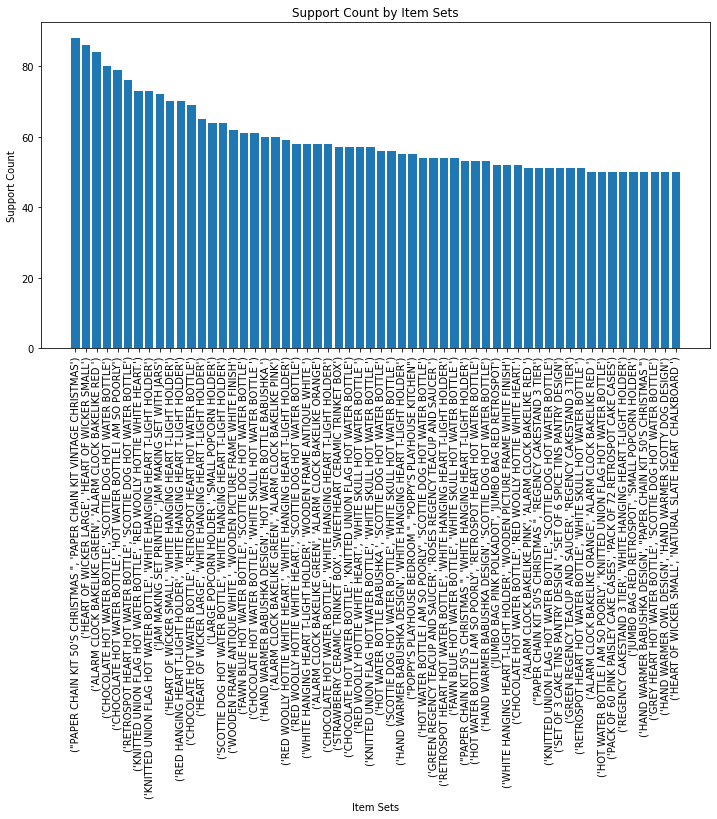

In [18]:
import matplotlib.pyplot as plt
freq_item_sets = freq_item_sets.sort_values(by='supp_count', ascending=False)

# create a wider plot
fig, ax = plt.subplots(figsize=(12, 6))

# create a bar plot of the supp_count column
ax.bar(freq_item_sets['item_sets'].apply(str), freq_item_sets['supp_count'])

# add labels to the plot
ax.set_title('Support Count by Item Sets')
ax.set_xlabel('Item Sets')
ax.set_ylabel('Support Count')
ax.tick_params(axis='x', rotation=90)
plt.show()

<ipython-input-19-c66ba34206ed>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(item_df.index, rotation=90)


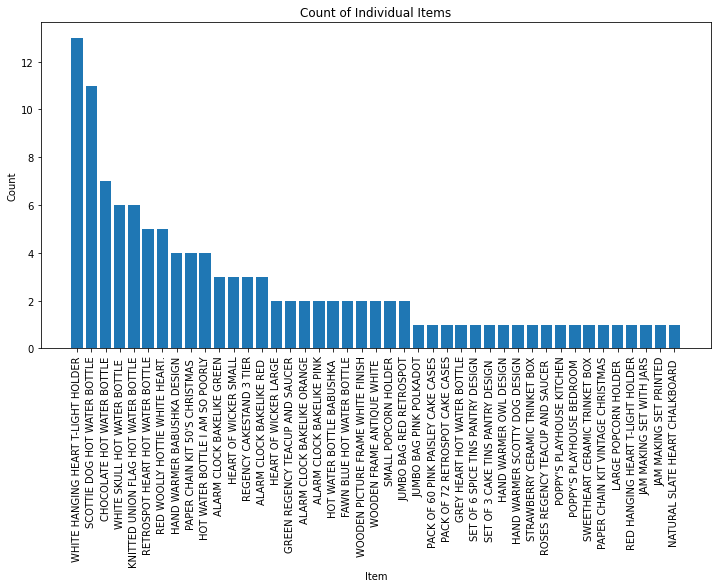

In [19]:
item_counts = {}

# iterate over each item set in the dataframe
for item_set in freq_item_sets['item_sets']:
    for item in item_set:
        # if the item is already in the dictionary, increment its count
        if item in item_counts:
            item_counts[item] += 1
        # if the item is not in the dictionary, add it with a count of 1
        else:
            item_counts[item] = 1

# convert the dictionary to a dataframe
item_df = pd.DataFrame.from_dict(item_counts, orient='index', columns=['count'])


# sort the dataframe by count in descending order
item_df = item_df.sort_values(by='count', ascending=False)

# create a wider bar plot of the count column
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(item_df.index, item_df['count'])

# add labels to the plot
ax.set_title('Count of Individual Items')
ax.set_xlabel('Item')
ax.set_xticklabels(item_df.index, rotation=90)
ax.set_ylabel('Count')

# create a scatter plot of supp_count versus index
# fig, ax = plt.subplots()
# ax.scatter(freq_item_sets.index, freq_item_sets['supp_count'])

# # add labels to the plot
# ax.set_title('Support Count Distribution')
# ax.set_xlabel('Index')
# ax.set_ylabel('Support Count')

# show the plots
plt.show()

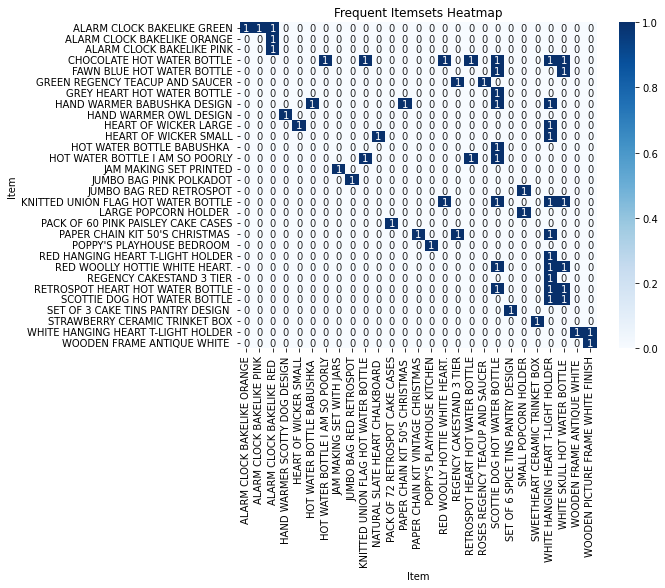

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the frequent itemsets to a dataframe
df = freq_item_sets['item_sets'].apply(pd.Series)

# Count the support for each pair
support = df.groupby(df.columns.tolist()).size().unstack(fill_value=0)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(support, cmap='Blues', annot=True, fmt='d')
plt.title('Frequent Itemsets Heatmap')
plt.xlabel('Item')
plt.ylabel('Item')
plt.show()


# The output of the code is a heatmap that visualizes the support count for each pair of items in your dataset. 
# The rows and columns of the heatmap represent the unique items in your dataset, and the color of each cell
# represents the support count for the corresponding pair of items.

# The darker the color, the higher the support count. The heatmap also includes
# annotations of the exact support count for each pair of items, which helps to identify
# the most frequent pairs of items in your dataset.

# Overall, this visualization helps to identify the most commonly co-occurring items in your dataset,
# which can be useful for understanding customer behavior or identifying patterns in transaction data.